# TP2 - Foundations of Parallel Computing

**Author:** Imad Kissami  
**Date:** January 2026

This notebook covers fundamental concepts in parallel computing including:
- Loop optimizations and unrolling
- Instruction scheduling and compiler optimizations
- Amdahl's Law (strong scaling)
- Gustafson's Law (weak scaling)
- Performance analysis and profiling

## Table of Contents

1. [Exercise 1: Loop Optimizations](#exercise-1)
2. [Exercise 2: Instruction Scheduling](#exercise-2)
3. [Exercise 3: Amdahl's and Gustafson's Laws](#exercise-3)
4. [Exercise 4: Matrix Multiplication Analysis](#exercise-4)

In [3]:
# Import necessary libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import subprocess
import os
import time
from IPython.display import display, HTML

# Set plotting style
plt.style.use('seaborn-v0_8-darkgrid')
%matplotlib inline

---

# Exercise 1: Loop Optimizations <a id="exercise-1"></a>

## Concepts

### Loop Unrolling
Loop unrolling is a compiler optimization technique that:
- **Reduces loop overhead**: Fewer iterations mean fewer condition checks and jumps
- **Increases ILP (Instruction-Level Parallelism)**: More independent operations can execute in parallel
- **Improves cache utilization**: Better spatial locality

### Memory Bandwidth
Performance is often limited by:
- **Compute-bound**: CPU speed is the bottleneck
- **Memory-bound**: Memory bandwidth is the bottleneck

The theoretical minimum time is:
$$T_{min} \approx \frac{N \times sizeof(type)}{BW}$$

where BW is the memory bandwidth in bytes/second.

## Task 1: Create C files with different unrolling factors

In [ ]:
import os

# Create directory
os.makedirs('ex1', exist_ok=True)

def generate_unrolled_code(unroll_factor, data_type='double'):
    """
    Generate C code with manual loop unrolling + better timing
    """
    if data_type == 'double':
        init_val = '1.0'
        sum_type = 'double'
        format_spec = '%.1f'
        size_comment = '8 bytes'
    elif data_type == 'float':
        init_val = '1.0f'
        sum_type = 'float'
        format_spec = '%.1f'
        size_comment = '4 bytes'
    elif data_type == 'int':
        init_val = '1'
        sum_type = 'long long'
        format_spec = '%lld'
        size_comment = '4 bytes'
    elif data_type == 'short':
        init_val = '1'
        sum_type = 'long long'
        format_spec = '%lld'
        size_comment = '2 bytes'
    else:
        raise ValueError("Unsupported data type")

    unroll_body = ' + '.join(f'a[i + {j}]' for j in range(unroll_factor))

    code = f'''#include <stdio.h>
#include <stdlib.h>
#include <time.h>

#define N 100000000ULL          // 100 million elements

int main(void) {{
    {data_type} *a = malloc(N * sizeof({data_type}));
    if (!a) {{
        fprintf(stderr, "malloc failed\\n");
        return 1;
    }}

    {sum_type} sum = 0;
    volatile {sum_type} sink;           // prevent optimization away

    // Warm-up + initialize array
    for (size_t i = 0; i < N; i++) {{
        a[i] = {init_val};
    }}

    // Warm-up loops (bring data into cache, stabilize frequency)
    for (int rep = 0; rep < 3; rep++) {{
        sum = 0;
        int limit = N - (N % {unroll_factor});
        for (size_t i = 0; i < limit; i += {unroll_factor}) {{
            sum += {unroll_body};
        }}
        for (size_t i = limit; i < N; i++) {{
            sum += a[i];
        }}
    }}

    // Real measurement ── take the best of 5 runs
    double best_time_ms = 1e9;

    for (int rep = 0; rep < 5; rep++) {{
        sum = 0;

        struct timespec t1, t2;
        clock_gettime(CLOCK_MONOTONIC, &t1);

        int limit = N - (N % {unroll_factor});
        for (size_t i = 0; i < limit; i += {unroll_factor}) {{
            sum += {unroll_body};
        }}
        for (size_t i = limit; i < N; i++) {{
            sum += a[i];
        }}

        clock_gettime(CLOCK_MONOTONIC, &t2);

        double dt_ms = (t2.tv_sec - t1.tv_sec) * 1000.0 +
                       (t2.tv_nsec - t1.tv_nsec) / 1000000.0;

        if (dt_ms < best_time_ms) best_time_ms = dt_ms;
    }}

    sink = sum;     // force use of result

    printf("U=%2d | Type=%-6s | Sum={format_spec} | Time=%.3f ms | %s\\n",
           {unroll_factor}, "{data_type}", sink, best_time_ms, "{size_comment}");

    free(a);
    return 0;
}}
'''
    return code


unroll_factors = [1, 2, 3, 4, 6, 8, 10, 12, 16, 32]
data_types     = ['double', 'float', 'int', 'short']

print("Generating C files...\n")

for dtype in data_types:
    for U in unroll_factors:
        filename = f'ex1/loop_unroll_U{U:02d}_{dtype}.c'
        code_str = generate_unrolled_code(U, dtype)
        with open(filename, 'w', encoding='utf-8') as f:
            f.write(code_str)
        print(f"  created: {filename}")

print(f"\nDone. {len(unroll_factors)*len(data_types)} files generated.")
print("Next step: compile & run each file with -O0, -O2")

Generating C files...

  created: ex1/loop_unroll_U01_double.c
  created: ex1/loop_unroll_U02_double.c
  created: ex1/loop_unroll_U03_double.c
  created: ex1/loop_unroll_U04_double.c
  created: ex1/loop_unroll_U06_double.c
  created: ex1/loop_unroll_U08_double.c
  created: ex1/loop_unroll_U10_double.c
  created: ex1/loop_unroll_U12_double.c
  created: ex1/loop_unroll_U16_double.c
  created: ex1/loop_unroll_U32_double.c
  created: ex1/loop_unroll_U01_float.c
  created: ex1/loop_unroll_U02_float.c
  created: ex1/loop_unroll_U03_float.c
  created: ex1/loop_unroll_U04_float.c
  created: ex1/loop_unroll_U06_float.c
  created: ex1/loop_unroll_U08_float.c
  created: ex1/loop_unroll_U10_float.c
  created: ex1/loop_unroll_U12_float.c
  created: ex1/loop_unroll_U16_float.c
  created: ex1/loop_unroll_U32_float.c
  created: ex1/loop_unroll_U01_int.c
  created: ex1/loop_unroll_U02_int.c
  created: ex1/loop_unroll_U03_int.c
  created: ex1/loop_unroll_U04_int.c
  created: ex1/loop_unroll_U06_int.c
  

## Task 2: Compile and run with different optimization levels

In [ ]:
import os
import subprocess
import numpy as np
import pandas as pd

BASE_DIR = os.path.abspath("ex1")
print("Working directory for compilation and execution:", BASE_DIR)

if not os.path.isdir(BASE_DIR):
    print(f"Error: Directory {BASE_DIR} does not exist!")
else:
    print(f"Number of .c files found: {len([f for f in os.listdir(BASE_DIR) if f.endswith('.c')])}")

unroll_factors = [1, 2, 3, 4, 6, 8, 10, 12, 16, 32]
data_types = ['double', 'float', 'int', 'short']

def compile_and_run(U, dtype, opt_level='O0'):
    """
    Compile one file → run it 5 times → return median time
    """
    source_file = os.path.join(BASE_DIR, f"loop_unroll_U{U:02d}_{dtype}.c")
    
    if not os.path.isfile(source_file):
        print(f"Source file not found: {source_file}")
        return None

    base_name = os.path.splitext(os.path.basename(source_file))[0]
    executable = os.path.join(BASE_DIR, f'{base_name}_{opt_level}.exe')

    compile_cmd = ['gcc', f'-{opt_level}', '-march=native', source_file, '-o', executable, '-lm']
    result = subprocess.run(compile_cmd, capture_output=True, text=True)
    
    if result.returncode != 0:
        print(f"Compilation failed ({opt_level}) for {source_file}:\n{result.stderr.strip()}")
        return None

    times = []
    for run_idx in range(5):
        try:
            res = subprocess.run(
                [executable],
                cwd=BASE_DIR,
                capture_output=True,
                text=True,
                check=True,
                timeout=90
            )
            output = res.stdout.strip()
            
            if 'Time=' not in output or 'ms' not in output:
                print(f"Invalid output format (run {run_idx+1}):\n{output[:300]}...")
                continue

            try:
                time_part = output.split('Time=')[1].split('ms')[0].strip()
                t_ms = float(time_part)
                times.append(t_ms)
            except (IndexError, ValueError):
                print(f"Could not parse time from output (run {run_idx+1}):\n{output[:300]}...")
                continue

        except subprocess.TimeoutExpired:
            print(f"Timeout in run {run_idx+1} for {executable}")
        except subprocess.CalledProcessError as e:
            print(f"Run {run_idx+1} failed:\n{e.stderr}")
        except Exception as e:
            print(f"Unexpected error in run {run_idx+1}: {e}")

    try:
        os.remove(executable)
    except OSError:
        pass

    if not times:
        print(f"No valid times collected for U={U} {dtype} {opt_level}")
        return None

    median_time = np.median(times)
    count = len(times)
    print(f"  U={U:2d} {dtype:6s} {opt_level} → {count} valid runs | median = {median_time:7.3f} ms "
          f"| min = {min(times):6.3f} | max = {max(times):6.3f}")

    return median_time



results = []

for dtype in data_types:
    for U in unroll_factors:
        print(f"\nStarting: {dtype} U={U}")
        
        time_O0 = compile_and_run(U, dtype, 'O0')
        time_O2 = compile_and_run(U, dtype, 'O2')
        
        results.append({
            'Type': dtype,
            'Unroll_Factor': U,
            'Time_O0_ms': time_O0,
            'Time_O2_ms': time_O2
        })
        
        print(f"Completed: {dtype} U={U}")


df_ex1 = pd.DataFrame(results)
display(df_ex1)

df_ex1.to_csv(os.path.join(BASE_DIR, "exercise1_results.csv"), index=False)
print("Results saved to exercise1_results.csv")

Working directory for compilation and execution: c:\Users\ZBooK\Documents\Parallel-DistributedProgramming-Assignments\TP2\ex1
Number of .c files found: 40

Starting: double U=1
  U= 1 double O0 → 5 valid runs | median = 515.193 ms | min = 446.010 | max = 540.135
  U= 1 double O2 → 5 valid runs | median = 149.000 ms | min = 127.135 | max = 161.981
Completed: double U=1

Starting: double U=2
  U= 2 double O0 → 5 valid runs | median = 274.528 ms | min = 250.158 | max = 294.501
  U= 2 double O2 → 5 valid runs | median = 118.851 ms | min = 102.371 | max = 124.801
Completed: double U=2

Starting: double U=3
  U= 3 double O0 → 5 valid runs | median = 183.959 ms | min = 178.701 | max = 194.700
  U= 3 double O2 → 5 valid runs | median = 107.292 ms | min = 97.253 | max = 116.404
Completed: double U=3

Starting: double U=4
  U= 4 double O0 → 5 valid runs | median = 167.699 ms | min = 150.123 | max = 181.067
  U= 4 double O2 → 5 valid runs | median = 119.321 ms | min = 113.045 | max = 121.432
Comp

,Type,Unroll_Factor,Time_O0_ms,Time_O2_ms
0,double,1,515.193,149.000
1,double,2,274.528,118.851
2,double,3,183.959,107.292
3,double,4,167.699,119.321
4,double,6,132.827,102.347
5,double,8,133.367,126.635
6,double,10,135.898,107.195
7,double,12,141.517,98.477
8,double,16,131.294,126.485
9,double,32,114.335,156.088


Results saved to exercise1_results.csv


## Task 3: Visualize results

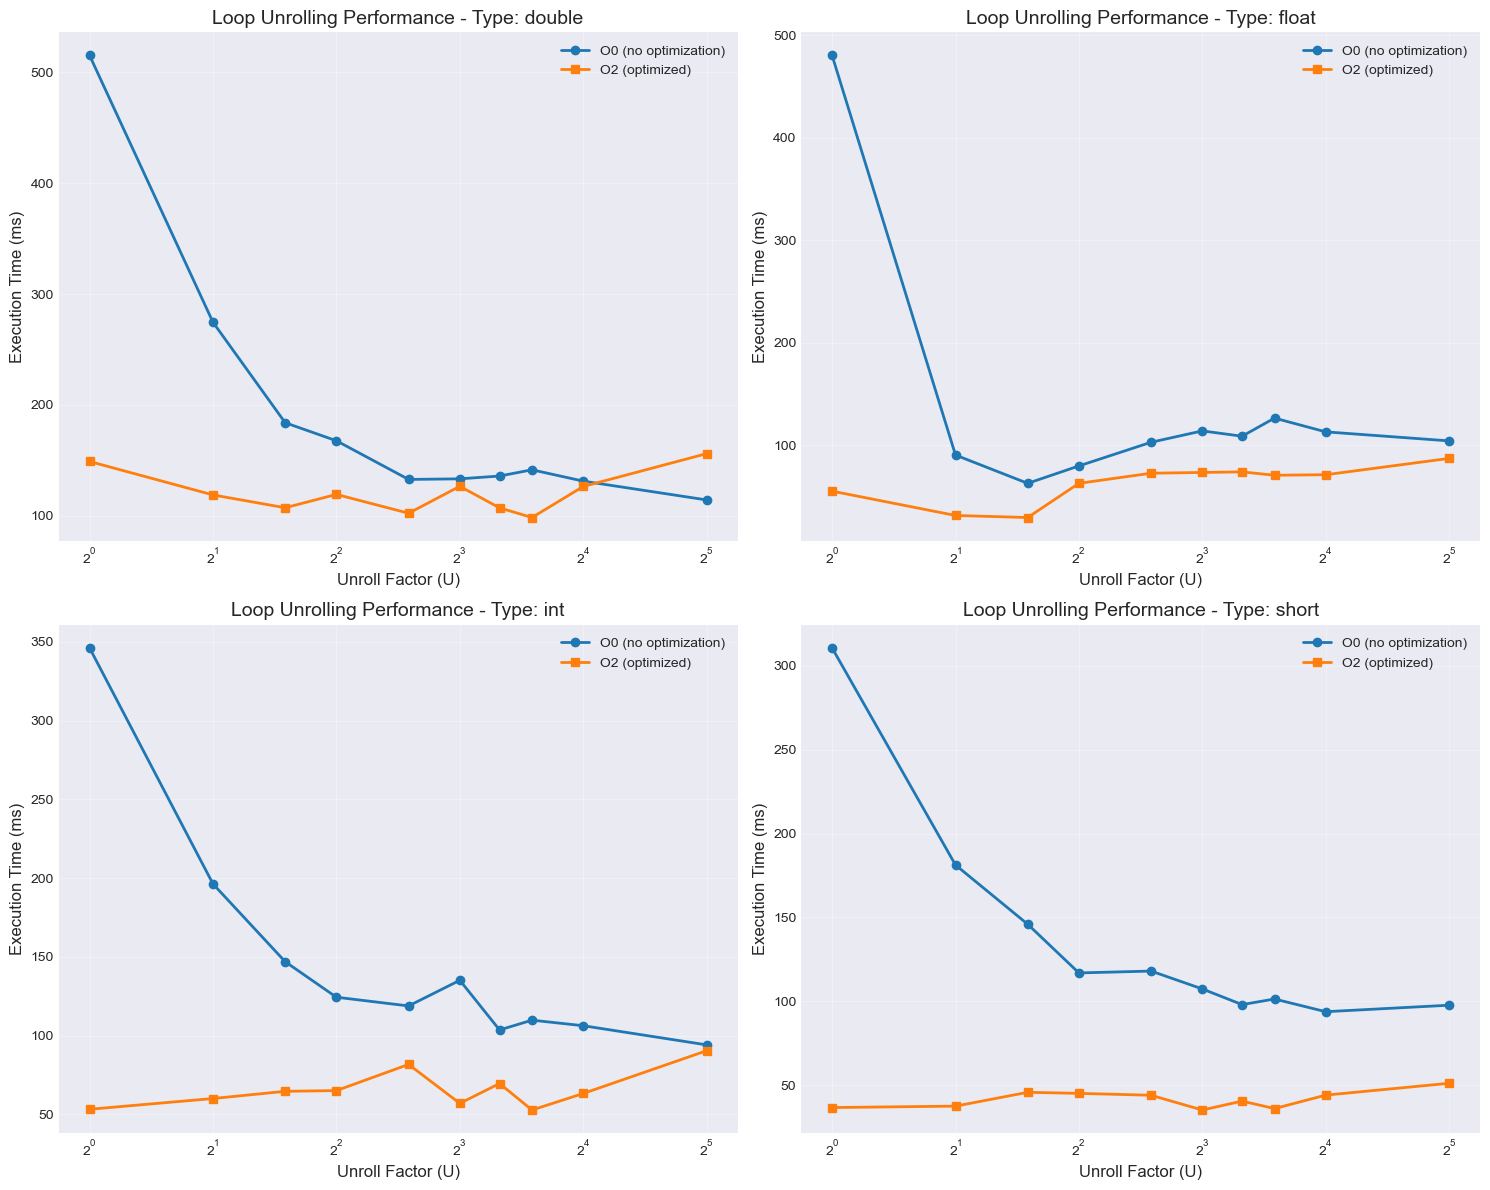


=== Analysis ===

Type: double
  Best unroll factor at O0: U=32
  Best unroll factor at O2: U=12

Type: float
  Best unroll factor at O0: U=3
  Best unroll factor at O2: U=3

Type: int
  Best unroll factor at O0: U=32
  Best unroll factor at O2: U=12

Type: short
  Best unroll factor at O0: U=16
  Best unroll factor at O2: U=8


In [ ]:
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
axes = axes.flatten()

for idx, dtype in enumerate(data_types):
    df_type = df_ex1[df_ex1['Type'] == dtype]
    
    axes[idx].plot(df_type['Unroll_Factor'], df_type['Time_O0_ms'], 
                   marker='o', label='O0 (no optimization)', linewidth=2)
    axes[idx].plot(df_type['Unroll_Factor'], df_type['Time_O2_ms'], 
                   marker='s', label='O2 (optimized)', linewidth=2)
    
    axes[idx].set_xlabel('Unroll Factor (U)', fontsize=12)
    axes[idx].set_ylabel('Execution Time (ms)', fontsize=12)
    axes[idx].set_title(f'Loop Unrolling Performance - Type: {dtype}', fontsize=14)
    axes[idx].legend()
    axes[idx].grid(True, alpha=0.3)
    axes[idx].set_xscale('log', base=2)

plt.tight_layout()
plt.savefig('ex1/loop_unrolling_results.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n=== Analysis ===")
for dtype in data_types:
    df_type = df_ex1[df_ex1['Type'] == dtype]
    best_U_O0 = df_type.loc[df_type['Time_O0_ms'].idxmin()]['Unroll_Factor']
    best_U_O2 = df_type.loc[df_type['Time_O2_ms'].idxmin()]['Unroll_Factor']
    print(f"\nType: {dtype}")
    print(f"  Best unroll factor at O0: U={int(best_U_O0)}")
    print(f"  Best unroll factor at O2: U={int(best_U_O2)}")

## Task 4: Memory bandwidth analysis

In [29]:
# Corrected and clean version for question 7 (memory bandwidth bound)

import pandas as pd
import numpy as np

N = 100000000


bandwidth_GBps = 20.0

bandwidth_Bps = bandwidth_GBps * 1e9  # bytes per second

type_sizes = {
    'double': 8,
    'float':  4,
    'int':    4,
    'short':  2
}

print("=== Memory Bandwidth Analysis (Question 7) ===")
print(f"Assumed single-core streaming bandwidth: {bandwidth_GBps} GB/s")
print(f"Number of elements: {N:,}\n")

for dtype in ['double', 'float', 'int', 'short']:
    elem_size = type_sizes[dtype]
    total_bytes = N * elem_size
    total_MB = total_bytes / 1_000_000
    
    T_min_sec = total_bytes / bandwidth_Bps
    T_min_ms  = T_min_sec * 1000
    
    df_type = df_ex1[df_ex1['Type'] == dtype]
    best_time_O2_ms = df_type['Time_O2_ms'].min()
    
    measured_sec = best_time_O2_ms / 1000
    achieved_GBps = total_bytes / measured_sec / 1e9 if measured_sec > 0 else 0
    
    # Efficiency = (theoretical min time) / (measured time)
    efficiency_pct = (T_min_ms / best_time_O2_ms) * 100 if best_time_O2_ms > 0 else 0
    
    print(f"Type: {dtype}")
    print(f"  Total data size:     {total_MB:8.2f} MB")
    print(f"  Theoretical min time @ {bandwidth_GBps} GB/s: {T_min_ms:7.2f} ms")
    print(f"  Best measured time (-O2):               {best_time_O2_ms:7.2f} ms")
    print(f"  Achieved effective bandwidth:           {achieved_GBps:5.1f} GB/s")
    print(f"  Efficiency (how close to theoretical):  {efficiency_pct:5.1f} %")
    print()

=== Memory Bandwidth Analysis (Question 7) ===
Assumed single-core streaming bandwidth: 20.0 GB/s
Number of elements: 100,000,000

Type: double
  Total data size:       800.00 MB
  Theoretical min time @ 20.0 GB/s:   40.00 ms
  Best measured time (-O2):                 98.48 ms
  Achieved effective bandwidth:             8.1 GB/s
  Efficiency (how close to theoretical):   40.6 %

Type: float
  Total data size:       400.00 MB
  Theoretical min time @ 20.0 GB/s:   20.00 ms
  Best measured time (-O2):                 29.23 ms
  Achieved effective bandwidth:            13.7 GB/s
  Efficiency (how close to theoretical):   68.4 %

Type: int
  Total data size:       400.00 MB
  Theoretical min time @ 20.0 GB/s:   20.00 ms
  Best measured time (-O2):                 52.72 ms
  Achieved effective bandwidth:             7.6 GB/s
  Efficiency (how close to theoretical):   37.9 %

Type: short
  Total data size:       200.00 MB
  Theoretical min time @ 20.0 GB/s:   10.00 ms
  Best measured time (-

## Key Insights from Exercise 1

1. **Loop Unrolling Benefits**:
   - Reduces loop overhead (fewer branches, increments)
   - Increases ILP (Instruction-Level Parallelism)
   - Improves register utilization

2. **Performance Saturation**:
   - Initially, performance improves with increasing U
   - Eventually saturates when memory bandwidth becomes the bottleneck
   - Further unrolling doesn't help if we're memory-bound

3. **Compiler Optimization**:
   - O2 often performs automatic loop unrolling
   - Manual unrolling at O0 can match or beat O2 for optimal U
   - At O2, manual unrolling may provide minimal additional benefit

4. **Data Type Effects**:
   - Smaller types (short, int) transfer less data
   - May achieve better bandwidth utilization
   - But may have different computational characteristics

---

# Exercise 2: Instruction Scheduling <a id="exercise-2"></a>

## Concepts

### Instruction Scheduling
Modern CPUs can execute multiple instructions simultaneously through:
- **Pipelining**: Different stages of different instructions execute in parallel
- **Superscalar execution**: Multiple instructions enter the pipeline per cycle
- **Out-of-order execution**: CPU reorders instructions to avoid stalls

### Data Dependencies
- **RAW (Read After Write)**: True dependency - must preserve order
- **WAR (Write After Read)**: Anti-dependency - can be eliminated by renaming
- **WAW (Write After Write)**: Output dependency - can be eliminated by renaming

### Independent Operations
Operations on `x` and `y` are independent and can be:
- Scheduled in parallel
- Executed on different functional units
- Benefit from register renaming

## Task 1: Create test programs

In [ ]:
import os

# Create directory
os.makedirs('ex2', exist_ok=True)


code_original = '''#include <stdio.h>
#include <stdlib.h>
#include <time.h>

#define N 100000000LL

int main() {
    double a = 1.1, b = 1.2;
    double x = 0.0, y = 0.0;
    clock_t start, end;
    
    start = clock();
    for (long long i = 0; i < N; i++) {
        x = a * b + x;  // stream 1
        y = a * b + y;  // stream 2
    }
    end = clock();
    
    printf("x = %f, y = %f, time = %.6f s\\n", 
           x, y, (double)(end - start) / CLOCKS_PER_SEC);
    return 0;
}
'''

code_optimized = '''#include <stdio.h>
#include <stdlib.h>
#include <time.h>

#define N 100000000LL

int main() {
    double a = 1.1, b = 1.2;
    double x = 0.0, y = 0.0;
    clock_t start, end;
    
    double ab = a * b;  // compute once outside loop

    start = clock();
    for (long long i = 0; i < N; i++) {
        x += ab;
        y += ab;
    }
    end = clock();
    
    printf("x = %f, y = %f, time = %.6f s\\n", 
           x, y, (double)(end - start) / CLOCKS_PER_SEC);
    return 0;
}
'''

# Write both files
with open('ex2/instruction_scheduling_original.c', 'w', encoding='utf-8') as f:
    f.write(code_original)

with open('ex2/instruction_scheduling_optimized.c', 'w', encoding='utf-8') as f:
    f.write(code_optimized)

print("Generated C source files for Exercise 2:")
print("  → ex2/instruction_scheduling_original.c")
print("  → ex2/instruction_scheduling_optimized.c")
print("\nNext step: compile & run them with -O0 and -O2")

Generated C source files for Exercise 2:
  → ex2/instruction_scheduling_original.c
  → ex2/instruction_scheduling_optimized.c

Next step: compile & run them with -O0 and -O2


## Task 2: Compile and analyze assembly

In [ ]:
import os
import subprocess


os.makedirs('ex2', exist_ok=True)

def compile_to_assembly(source_file, opt_level='O0'):
    """
    Compile C code to Intel-syntax assembly.
    Returns path to .s file or None if failed.
    """
    if not os.path.isfile(source_file):
        print(f"Error: Source file not found: {source_file}")
        return None

    base_name = os.path.splitext(os.path.basename(source_file))[0]
    asm_file = os.path.join('ex2', f'{base_name}_{opt_level}.s')
    
    cmd = [
        'gcc',
        f'-{opt_level}',
        '-fno-omit-frame-pointer',
        '-S',               # generate assembly
        '-masm=intel',      # Intel syntax
        source_file,
        '-o', asm_file
    ]
    
    result = subprocess.run(cmd, capture_output=True, text=True)
    
    if result.returncode != 0:
        print(f"Compilation failed for {source_file} ({opt_level}):")
        print(result.stderr.strip())
        return None
    
    print(f"Generated: {asm_file}")
    return asm_file


versions = ['original', 'optimized']
opt_levels = ['O0', 'O2']

print("Generating assembly files for Exercise 2...\n")

asm_files = []

for version in versions:
    source = f'ex2/instruction_scheduling_{version}.c'
    for opt in opt_levels:
        asm = compile_to_assembly(source, opt)
        if asm:
            asm_files.append(asm)

if asm_files:
    print("\nAll assembly files generated successfully.")
    print("Next steps:")
    print("1. Open the .s files (especially *_O0.s vs *_O2.s)")
    print("2. Compare the loop body:")
    print("   - At -O0: expect repeated mulsd + loads of a/b")
    print("   - At -O2: expect hoisted multiply + only adds (addsd)")
    print("3. Look for optimizations like:")
    print("   - removal of redundant loads")
    print("   - loop-invariant code motion (a*b outside)")
    print("   - possible unrolling or vectorization at -O2")
else:
    print("\nNo assembly files generated — check paths and gcc installation.")

Generating assembly files for Exercise 2...

Generated: ex2\instruction_scheduling_original_O0.s
Generated: ex2\instruction_scheduling_original_O2.s
Generated: ex2\instruction_scheduling_optimized_O0.s
Generated: ex2\instruction_scheduling_optimized_O2.s

All assembly files generated successfully.
Next steps:
1. Open the .s files (especially *_O0.s vs *_O2.s)
2. Compare the loop body:
   - At -O0: expect repeated mulsd + loads of a/b
   - At -O2: expect hoisted multiply + only adds (addsd)
3. Look for optimizations like:
   - removal of redundant loads
   - loop-invariant code motion (a*b outside)
   - possible unrolling or vectorization at -O2


## Task 3: Measure execution times

In [ ]:
import os
import subprocess
import numpy as np
import pandas as pd
import re

os.makedirs('ex2', exist_ok=True)

def run_timed_executable(source_file, opt_level='O0', num_runs=5):
    """
    Compile a C file → run it num_runs times → return mean time in seconds.
    """
    source_file = os.path.abspath(source_file)
    base_name = os.path.splitext(os.path.basename(source_file))[0]
    executable = os.path.join('ex2', f'{base_name}_{opt_level}')

    compile_cmd = [
        'gcc',
        f'-{opt_level}',
        '-march=native',
        '-fno-omit-frame-pointer',   
        source_file,
        '-o', executable,
        '-lm'
    ]
    
    compile_result = subprocess.run(compile_cmd, capture_output=True, text=True)
    
    if compile_result.returncode != 0:
        print(f"Compilation failed ({opt_level}) for {source_file}:")
        print(compile_result.stderr.strip())
        return None

    # Run multiple times
    times = []
    for run_idx in range(num_runs):
        try:
            res = subprocess.run(
                [executable],
                cwd=os.path.dirname(executable),  # run from ex2/
                capture_output=True,
                text=True,
                check=True,
                timeout=120
            )
            output = res.stdout.strip()
            
            match = re.search(r'time\s*=\s*([\d\.e+-]+)\s*s', output, re.IGNORECASE)
            if not match:
                print(f"Run {run_idx+1}: could not find 'time =' in output:")
                print(output[:300] + '...' if len(output) > 300 else output)
                continue
            
            t_sec = float(match.group(1))
            times.append(t_sec)
            
        except subprocess.TimeoutExpired:
            print(f"Run {run_idx+1}: timeout after 120s")
        except subprocess.CalledProcessError as e:
            print(f"Run {run_idx+1}: execution failed\n{e.stderr.strip()}")
        except Exception as e:
            print(f"Run {run_idx+1}: error - {e}")

    try:
        os.remove(executable)
    except OSError:
        pass

    if not times:
        print(f"No valid timings for {base_name} ({opt_level})")
        return None

    mean_time = np.mean(times)
    print(f"  {base_name:25} {opt_level}: {len(times)} runs | "
          f"mean = {mean_time:.6f} s  "
          f"(min = {min(times):.6f}, max = {max(times):.6f})")
    
    return mean_time



versions    = ['original', 'optimized']
opt_levels  = ['O0', 'O2']

results_ex2 = []

print("=== Exercise 2 – Timing measurements ===\n")

for version in versions:
    source_path = f'ex2/instruction_scheduling_{version}.c'
    
    if not os.path.isfile(source_path):
        print(f"Source file missing: {source_path}")
        continue
    
    for opt in opt_levels:
        print(f"Running: {version} / {opt}")
        time_s = run_timed_executable(source_path, opt, num_runs=5)
        
        results_ex2.append({
            'Version': version,
            'Optimization': opt,
            'Time_s_mean': time_s,
            'Time_s (mean)': f"{time_s:.6f}" if time_s is not None else "Failed"
        })
        print()


if results_ex2:
    df_ex2 = pd.DataFrame(results_ex2)
    display(df_ex2)
    
    output_csv = 'ex2/exercise2_timing_results.csv'
    df_ex2.to_csv(output_csv, index=False)
    print(f"\nResults saved to: {output_csv}")
else:
    print("No results collected – check source files and compilation errors.")

=== Exercise 2 – Timing measurements ===

Running: original / O0
  instruction_scheduling_original O0: 5 runs | mean = 0.528200 s  (min = 0.474000, max = 0.601000)

Running: original / O2
  instruction_scheduling_original O2: 5 runs | mean = 0.078200 s  (min = 0.056000, max = 0.100000)

Running: optimized / O0
  instruction_scheduling_optimized O0: 5 runs | mean = 0.480400 s  (min = 0.461000, max = 0.523000)

Running: optimized / O2
  instruction_scheduling_optimized O2: 5 runs | mean = 0.062200 s  (min = 0.052000, max = 0.077000)



,Version,Optimization,Time_s_mean,Time_s (mean)
0,original,O0,0.5282,0.528200
1,original,O2,0.0782,0.078200
2,optimized,O0,0.4804,0.480400
3,optimized,O2,0.0622,0.062200



Results saved to: ex2/exercise2_timing_results.csv


## Task 4: Visualize and analyze results

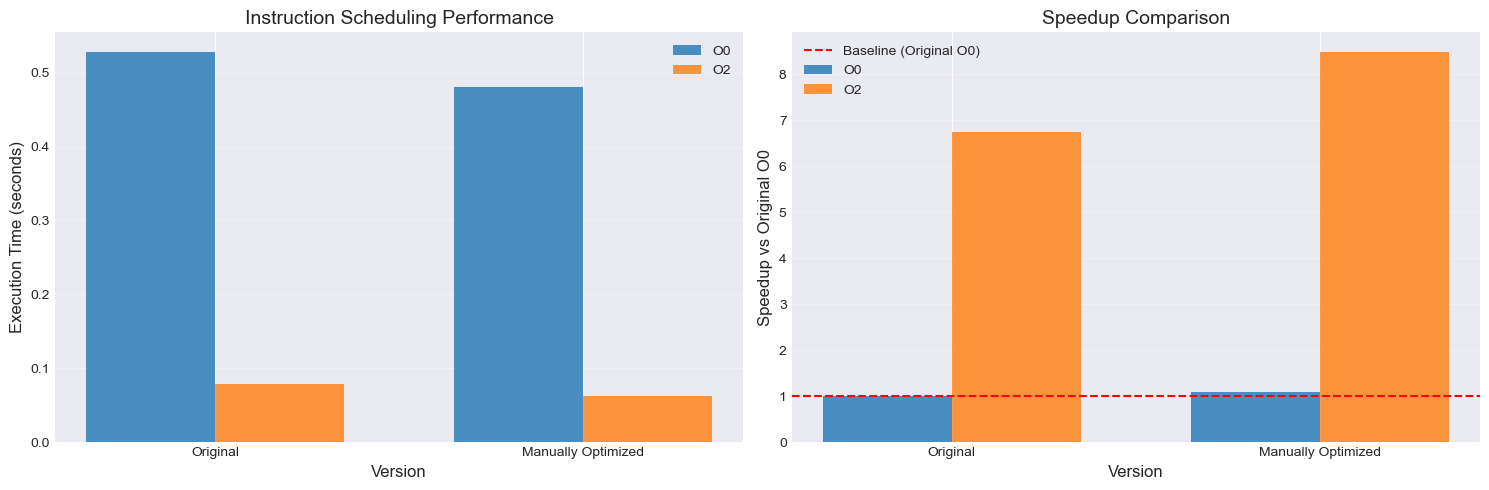


=== Analysis ===
Original O0:          0.5282 s (baseline)
Original O2:          0.0782 s (speedup: 6.75x)
Manual Optim O0:      0.4804 s (speedup: 1.10x)
Manual Optim O2:      0.0622 s (speedup: 8.49x)


In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
versions = ['original', 'optimized']
x_pos = np.arange(len(versions))
width = 0.35

times_O0 = [df_ex2[(df_ex2['Version']==v) & (df_ex2['Optimization']=='O0')]['Time_s_mean'].values[0] 
            for v in versions]
times_O2 = [df_ex2[(df_ex2['Version']==v) & (df_ex2['Optimization']=='O2')]['Time_s_mean'].values[0] 
            for v in versions]

ax1.bar(x_pos - width/2, times_O0, width, label='O0', alpha=0.8)
ax1.bar(x_pos + width/2, times_O2, width, label='O2', alpha=0.8)
ax1.set_xlabel('Version', fontsize=12)
ax1.set_ylabel('Execution Time (seconds)', fontsize=12)
ax1.set_title('Instruction Scheduling Performance', fontsize=14)
ax1.set_xticks(x_pos)
ax1.set_xticklabels(['Original', 'Manually Optimized'])
ax1.legend()
ax1.grid(True, alpha=0.3, axis='y')

baseline_O0 = times_O0[0]
speedups_O0 = [baseline_O0 / t for t in times_O0]
speedups_O2 = [baseline_O0 / t for t in times_O2]

ax2.bar(x_pos - width/2, speedups_O0, width, label='O0', alpha=0.8)
ax2.bar(x_pos + width/2, speedups_O2, width, label='O2', alpha=0.8)
ax2.axhline(y=1, color='r', linestyle='--', label='Baseline (Original O0)')
ax2.set_xlabel('Version', fontsize=12)
ax2.set_ylabel('Speedup vs Original O0', fontsize=12)
ax2.set_title('Speedup Comparison', fontsize=14)
ax2.set_xticks(x_pos)
ax2.set_xticklabels(['Original', 'Manually Optimized'])
ax2.legend()
ax2.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig('ex2/instruction_scheduling_results.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n=== Analysis ===")
print(f"Original O0:          {times_O0[0]:.4f} s (baseline)")
print(f"Original O2:          {times_O2[0]:.4f} s (speedup: {speedups_O2[0]:.2f}x)")
print(f"Manual Optim O0:      {times_O0[1]:.4f} s (speedup: {speedups_O0[1]:.2f}x)")
print(f"Manual Optim O2:      {times_O2[1]:.4f} s (speedup: {speedups_O2[1]:.2f}x)")

## Key Insights from Exercise 2

1. **Compiler Optimizations at O2**:
   - Loop invariant code motion (moves `a*b` outside loop)
   - Instruction scheduling to minimize pipeline stalls
   - Register allocation optimization
   - Potential loop unrolling

2. **Manual Optimization Benefits**:
   - Multiple accumulators increase ILP
   - Reduces chain dependencies
   - Better utilization of execution units

3. **Independent Operations**:
   - Operations on x and y can execute in parallel
   - Modern CPUs can exploit this parallelism
   - Out-of-order execution helps hide latencies

4. **Comparison**:
   - Manual optimization at O0 can approach O2 performance
   - O2 compiler is sophisticated but not always optimal
   - Understanding low-level optimizations still valuable

---

# Exercise 3: Amdahl's and Gustafson's Laws <a id="exercise-3"></a>

## Concepts

### Amdahl's Law (Strong Scaling)
Describes the maximum speedup achievable when parallelizing a fixed-size problem:

$$S(p) = \frac{1}{f_s + \frac{f_p}{p}}$$

where:
- $f_s$ = sequential fraction (cannot be parallelized)
- $f_p$ = parallel fraction = $1 - f_s$
- $p$ = number of processors

**Maximum speedup**: $S_{\max} = \frac{1}{f_s}$

### Gustafson's Law (Weak Scaling)
Considers that problem size grows with number of processors:

$$S(p) = f_s + p \cdot f_p = p - f_s(p - 1)$$

More optimistic: assumes we scale problem size, not execution time.

### Sequential vs Parallel Code
- **Sequential**: `add_noise()` - each element depends on previous
- **Parallel**: `init_b()`, `compute_addition()`, `reduction()` - independent operations

## Task 1: Create the program and profile with Valgrind

In [30]:
import os

# Create directory
os.makedirs('ex3', exist_ok=True)

def generate_ex3_code(N):
    """Generate instrumented C code for Exercise 3 with given N."""
    code = f'''#include <stdio.h>
#include <stdlib.h>
#include <time.h>

#define N {N}LL   // Use long long literal for large N

void add_noise(double *a) {{
    a[0] = 1.0;
    for (long long i = 1; i < N; i++) {{
        a[i] = a[i-1] * 1.0000001;
    }}
}}

void init_b(double *b) {{
    for (long long i = 0; i < N; i++) {{
        b[i] = i * 0.5;
    }}
}}

void compute_addition(double *a, double *b, double *c) {{
    for (long long i = 0; i < N; i++) {{
        c[i] = a[i] + b[i];
    }}
}}

double reduction(double *c) {{
    double sum = 0.0;
    for (long long i = 0; i < N; i++) {{
        sum += c[i];
    }}
    return sum;
}}

int main() {{
    double *a = malloc(N * sizeof(double));
    double *b = malloc(N * sizeof(double));
    double *c = malloc(N * sizeof(double));
    
    if (!a || !b || !c) {{
        fprintf(stderr, "Malloc failed\\n");
        return 1;
    }}
    
    clock_t start, end;
    double t_add_noise = 0, t_init_b = 0, t_compute = 0, t_reduction = 0;
    
    // add_noise – strictly sequential
    start = clock();
    add_noise(a);
    end = clock();
    t_add_noise = (double)(end - start) / CLOCKS_PER_SEC;
    
    // init_b – parallelizable
    start = clock();
    init_b(b);
    end = clock();
    t_init_b = (double)(end - start) / CLOCKS_PER_SEC;
    
    // compute_addition – parallelizable
    start = clock();
    compute_addition(a, b, c);
    end = clock();
    t_compute = (double)(end - start) / CLOCKS_PER_SEC;
    
    // reduction – parallelizable (though reduction has inherent dependency)
    start = clock();
    double sum = reduction(c);
    end = clock();
    t_reduction = (double)(end - start) / CLOCKS_PER_SEC;
    
    printf("Sum = %.15f\\n", sum);
    printf("Time add_noise:        %.6f s\\n", t_add_noise);
    printf("Time init_b:           %.6f s\\n", t_init_b);
    printf("Time compute_addition: %.6f s\\n", t_compute);
    printf("Time reduction:        %.6f s\\n", t_reduction);
    
    free(a);
    free(b);
    free(c);
    return 0;
}}
'''
    return code


# Generate for the required N values (as in question 4)
N_values = [5000000, 10000000, 100000000]

for N in N_values:
    filename = f'ex3/ex3_N{N}.c'
    with open(filename, 'w', encoding='utf-8') as f:
        f.write(generate_ex3_code(N))
    print(f"Generated: {filename}")

print("\nAll Exercise 3 source files generated.")
print("Next steps:")
print("1. Compile each with: gcc -O2 -g ex3/ex3_N*.c -o ex3_N*")
print("2. Run Callgrind: valgrind --tool=callgrind ./ex3_N100000000")
print("3. Analyze with: callgrind_annotate callgrind.out.* | less")
print("   → Look for % of Ir in add_noise → that's fs")

Generated: ex3/ex3_N5000000.c
Generated: ex3/ex3_N10000000.c
Generated: ex3/ex3_N100000000.c

All Exercise 3 source files generated.
Next steps:
1. Compile each with: gcc -O2 -g ex3/ex3_N*.c -o ex3_N*
2. Run Callgrind: valgrind --tool=callgrind ./ex3_N100000000
3. Analyze with: callgrind_annotate callgrind.out.* | less
   → Look for % of Ir in add_noise → that's fs


## Task 2: Compile and measure execution times

In [38]:
import os
import subprocess
import re
import pandas as pd

def measure_execution_profile(source_file):
    """
    Compile with -O2 -g, run the program, parse the four timing values.
    Returns dict of times in seconds or None if failed.
    """
    source_file = os.path.abspath(source_file)
    base_name = os.path.splitext(os.path.basename(source_file))[0]
    executable = os.path.join('ex3', f'{base_name}_exe')

    # Compile with optimization + debug symbols
    compile_cmd = ['gcc', '-O2', '-g', source_file, '-o', executable, '-lm']
    compile_result = subprocess.run(compile_cmd, capture_output=True, text=True)
    
    if compile_result.returncode != 0:
        print(f"Compilation failed for {source_file}:")
        print(compile_result.stderr.strip())
        return None

    # Run the program
    try:
        run_result = subprocess.run(
            [executable],
            cwd='ex3',
            capture_output=True,
            text=True,
            check=True,
            timeout=300  # 5 min timeout (for N=1e8)
        )
    except Exception as e:
        print(f"Execution failed for {executable}: {e}")
        try:
            os.remove(executable)
        except:
            pass
        return None

    # Parse output
    output_lines = run_result.stdout.strip().split('\n')
    times = {}
    
    for line in output_lines:
        line = line.strip()
        if not line:
            continue
            
        # Match patterns like "Time add_noise:        0.123456 s"
        match = re.search(r'Time\s+(\w+(?:\s+\w+)?):\s*([\d\.]+)\s*s', line)
        if match:
            func_name = match.group(1).strip().replace(' ', '_')
            time_sec = float(match.group(2))
            times[func_name] = time_sec

    # Cleanup
    try:
        os.remove(executable)
    except:
        pass

    if len(times) != 4:
        print(f"Warning: Found only {len(times)} timings instead of 4 for {base_name}")
        print("Output was:")
        print(run_result.stdout[:500])
        return None

    return times


# ─── Run for all N values ────────────────────────────────────────

N_values = [5000000, 10000000, 100000000]

results_ex3 = []

print("=== Measuring execution times for different N (Exercise 3 – question 4) ===\n")

for N in N_values:
    source = f'ex3/ex3_N{N}.c'   # assuming you used the corrected naming
    print(f"Processing N = {N:,} ...")
    
    times = measure_execution_profile(source)
    
    if times:
        total_time = sum(times.values())
        seq_time = times.get('add_noise', 0)
        fs = seq_time / total_time if total_time > 0 else 0
        
        results_ex3.append({
            'N': N,
            'add_noise_s': times.get('add_noise', None),
            'init_b_s': times.get('init_b', None),
            'compute_addition_s': times.get('compute_addition', None),
            'reduction_s': times.get('reduction', None),
            'total_time_s': total_time,
            'sequential_fraction_fs': fs
        })
        
        print(f"  → fs = {fs:.4f}  (add_noise / total = {seq_time:.6f} / {total_time:.6f} s)")
        print(f"  Times: add_noise={times.get('add_noise', 'N/A'):.6f}s | "
              f"init_b={times.get('init_b', 'N/A'):.6f}s | "
              f"compute={times.get('compute_addition', 'N/A'):.6f}s | "
              f"reduction={times.get('reduction', 'N/A'):.6f}s")
        print()
    else:
        print("  → Measurement failed\n")

# ─── Results table ─────────────────────────────────────────────────
if results_ex3:
    df_ex3 = pd.DataFrame(results_ex3)
    display(df_ex3.round(6))
    
    # Save
    df_ex3.to_csv('ex3/ex3_timing_results.csv', index=False)
    print("Results saved to ex3/ex3_timing_results.csv")
else:
    print("No valid measurements collected.")

=== Measuring execution times for different N (Exercise 3 – question 4) ===

Processing N = 5,000,000 ...
  → fs = 0.2826  (add_noise / total = 0.013000 / 0.046000 s)
  Times: add_noise=0.013000s | init_b=0.009000s | compute=0.016000s | reduction=0.008000s

Processing N = 10,000,000 ...
  → fs = 0.2273  (add_noise / total = 0.020000 / 0.088000 s)
  Times: add_noise=0.020000s | init_b=0.018000s | compute=0.035000s | reduction=0.015000s

Processing N = 100,000,000 ...
  → fs = 0.2135  (add_noise / total = 0.351000 / 1.644000 s)
  Times: add_noise=0.351000s | init_b=0.517000s | compute=0.606000s | reduction=0.170000s



,N,add_noise_s,init_b_s,compute_addition_s,reduction_s,total_time_s,sequential_fraction_fs
0,5000000,0.013,0.009,0.016,0.008,0.046,0.282609
1,10000000,0.020,0.018,0.035,0.015,0.088,0.227273
2,100000000,0.351,0.517,0.606,0.170,1.644,0.213504


Results saved to ex3/ex3_timing_results.csv


## Task 3: Calculate and plot Amdahl's Law speedup

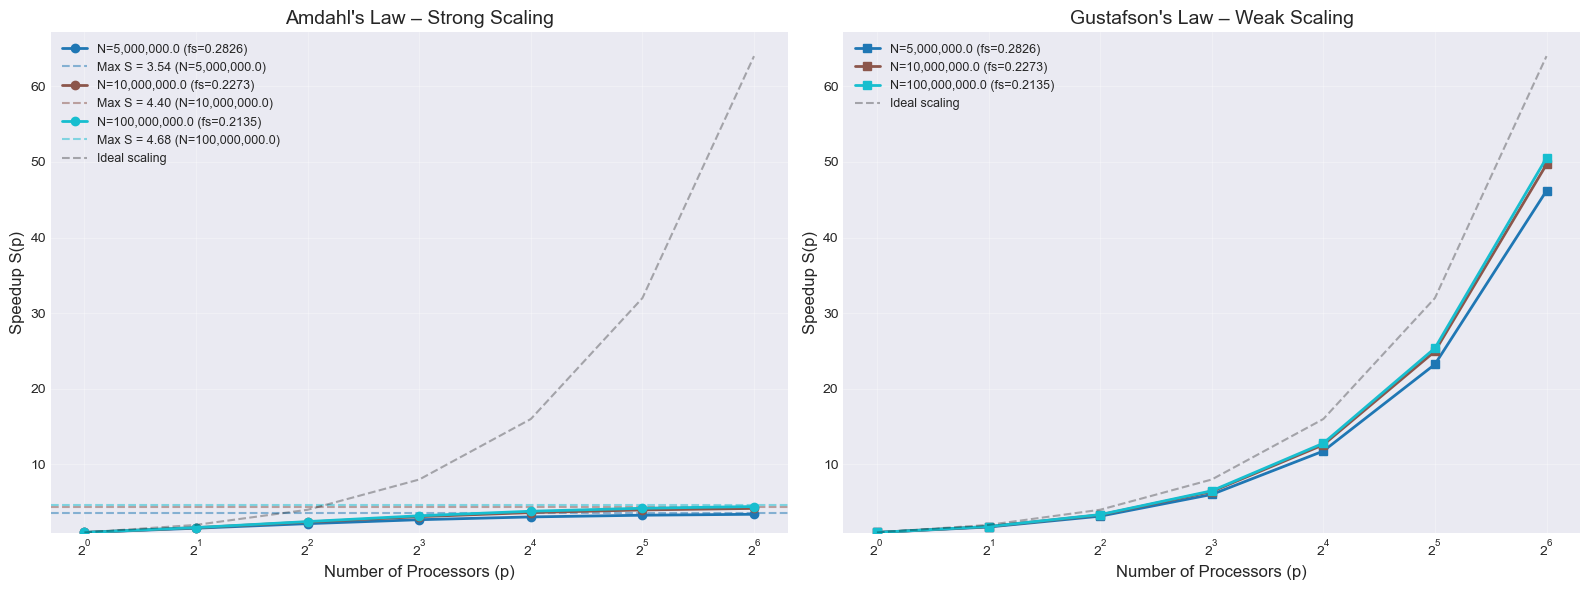


=== Amdahl's Law (Strong Scaling) ===

N = 5,000,000.0   fs = 0.2826   Max theoretical speedup = 3.54x
p   Speedup   Efficiency (%)
 1     1.00      100.0%
 2     1.56       78.0%
 4     2.16       54.1%
 8     2.69       33.6%
16     3.05       19.1%
32     3.28       10.2%
64     3.40        5.3%

N = 10,000,000.0   fs = 0.2273   Max theoretical speedup = 4.40x
p   Speedup   Efficiency (%)
 1     1.00      100.0%
 2     1.63       81.5%
 4     2.38       59.5%
 8     3.09       38.6%
16     3.63       22.7%
32     3.98       12.4%
64     4.18        6.5%

N = 100,000,000.0   fs = 0.2135   Max theoretical speedup = 4.68x
p   Speedup   Efficiency (%)
 1     1.00      100.0%
 2     1.65       82.4%
 4     2.44       61.0%
 8     3.21       40.1%
16     3.81       23.8%
32     4.20       13.1%
64     4.43        6.9%

=== Gustafson's Law (Weak Scaling) ===

N = 5,000,000.0   fs = 0.2826
p   Speedup
 1     1.00
 2     1.72
 4     3.15
 8     6.02
16    11.76
32    23.24
64    46.20

N = 

In [42]:
def amdahl_speedup(fs, p):
    """
    Calculate Amdahl's Law speedup.
    
    Args:
        fs: Sequential fraction
        p: Number of processors
    
    Returns:
        Speedup S(p)
    """
    fp = 1 - fs
    return 1 / (fs + fp / p)

def gustafson_speedup(fs, p):
    """
    Calculate Gustafson's Law speedup.
    
    Args:
        fs: Sequential fraction
        p: Number of processors
    
    Returns:
        Speedup S(p)
    """
    return p - fs * (p - 1)

import matplotlib.pyplot as plt
import numpy as np

# Make sure df_ex3 has 'N' and 'sequential_fraction_fs'
# (from your measurement cell)

# Processor counts (log scale)
p_values = np.array([1, 2, 4, 8, 16, 32, 64])

# Create figure
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Colors for different N values
colors = plt.cm.tab10(np.linspace(0, 1, len(df_ex3)))

# ─── Amdahl's Law (Strong Scaling) ──────────────────────────────────────
for idx, row in df_ex3.iterrows():
    N = row['N']
    fs = row['sequential_fraction_fs']
    if fs <= 0 or fs >= 1:
        continue
    
    speedups = [amdahl_speedup(fs, p) for p in p_values]
    max_s = 1 / fs if fs > 0 else np.inf
    
    color = colors[idx]
    ax1.plot(p_values, speedups, marker='o', linewidth=2, color=color,
             label=f'N={N:,} (fs={fs:.4f})')
    ax1.axhline(y=max_s, linestyle='--', alpha=0.5, color=color,
                label=f'Max S = {max_s:.2f} (N={N:,})')

ax1.plot(p_values, p_values, 'k--', alpha=0.3, label='Ideal scaling')
ax1.set_xlabel('Number of Processors (p)', fontsize=12)
ax1.set_ylabel('Speedup S(p)', fontsize=12)
ax1.set_title("Amdahl's Law – Strong Scaling", fontsize=14)
ax1.legend(fontsize=9, loc='upper left')
ax1.grid(True, alpha=0.3)
ax1.set_xscale('log', base=2)
ax1.set_ylim(0.9, None)

# ─── Gustafson's Law (Weak Scaling) ─────────────────────────────────────
for idx, row in df_ex3.iterrows():
    N = row['N']
    fs = row['sequential_fraction_fs']
    if fs <= 0 or fs >= 1:
        continue
    
    speedups = [gustafson_speedup(fs, p) for p in p_values]
    
    color = colors[idx]
    ax2.plot(p_values, speedups, marker='s', linewidth=2, color=color,
             label=f'N={N:,} (fs={fs:.4f})')

ax2.plot(p_values, p_values, 'k--', alpha=0.3, label='Ideal scaling')
ax2.set_xlabel('Number of Processors (p)', fontsize=12)
ax2.set_ylabel('Speedup S(p)', fontsize=12)
ax2.set_title("Gustafson's Law – Weak Scaling", fontsize=14)
ax2.legend(fontsize=9, loc='upper left')
ax2.grid(True, alpha=0.3)
ax2.set_xscale('log', base=2)
ax2.set_ylim(0.9, None)

plt.tight_layout()
plt.savefig('ex3/scaling_laws_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

# ─── Print tables ──────────────────────────────────────────────────────
print("\n=== Amdahl's Law (Strong Scaling) ===")
for _, row in df_ex3.iterrows():
    N = row['N']
    fs = row['sequential_fraction_fs']
    if fs <= 0 or fs >= 1:
        print(f"N={N:,}: invalid fs={fs:.4f} → skipped")
        continue
    
    print(f"\nN = {N:,}   fs = {fs:.4f}   Max theoretical speedup = {1/fs:.2f}x")
    print("p   Speedup   Efficiency (%)")
    for p in p_values:
        s = amdahl_speedup(fs, p)
        eff = (s / p) * 100
        print(f"{p:2d}   {s:6.2f}     {eff:6.1f}%")

print("\n=== Gustafson's Law (Weak Scaling) ===")
for _, row in df_ex3.iterrows():
    N = row['N']
    fs = row['sequential_fraction_fs']
    if fs <= 0 or fs >= 1:
        continue
    
    print(f"\nN = {N:,}   fs = {fs:.4f}")
    print("p   Speedup")
    for p in p_values:
        s = gustafson_speedup(fs, p)
        print(f"{p:2d}   {s:6.2f}")

## Task 4: Analyze effect of problem size

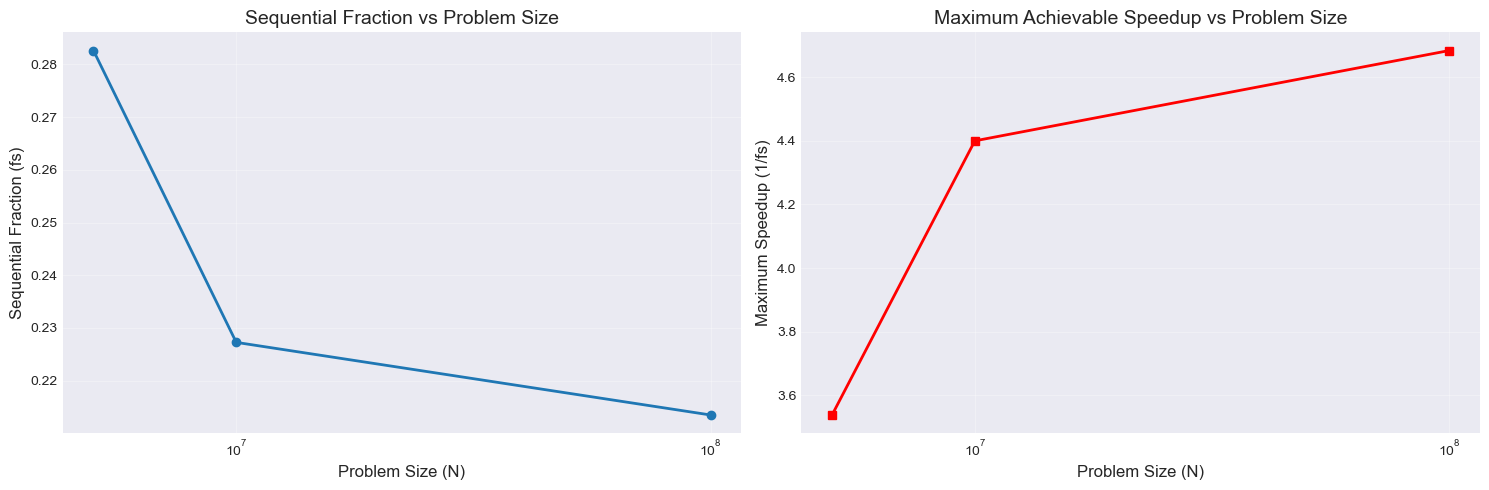


=== Effect of Problem Size ===
As N increases:
- Sequential fraction may change
- If fs decreases, maximum speedup increases
- Parallel portion becomes more dominant

This demonstrates that larger problems often parallelize better!


In [46]:
# Visualize how sequential fraction changes with N
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Sequential fraction vs N
ax1.plot(df_ex3['N'], df_ex3['sequential_fraction_fs'], marker='o', linewidth=2)
ax1.set_xlabel('Problem Size (N)', fontsize=12)
ax1.set_ylabel('Sequential Fraction (fs)', fontsize=12)
ax1.set_title('Sequential Fraction vs Problem Size', fontsize=14)
ax1.grid(True, alpha=0.3)
ax1.set_xscale('log')

# Maximum speedup vs N
max_speedups = [1/fs for fs in df_ex3['sequential_fraction_fs']]
ax2.plot(df_ex3['N'], max_speedups, marker='s', linewidth=2, color='red')
ax2.set_xlabel('Problem Size (N)', fontsize=12)
ax2.set_ylabel('Maximum Speedup (1/fs)', fontsize=12)
ax2.set_title('Maximum Achievable Speedup vs Problem Size', fontsize=14)
ax2.grid(True, alpha=0.3)
ax2.set_xscale('log')

plt.tight_layout()
plt.savefig('ex3/problem_size_effect.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n=== Effect of Problem Size ===")
print("As N increases:")
print("- Sequential fraction may change")
print("- If fs decreases, maximum speedup increases")
print("- Parallel portion becomes more dominant")
print("\nThis demonstrates that larger problems often parallelize better!")

## Key Insights from Exercise 3

1. **Sequential Bottleneck**:
   - `add_noise()` is inherently sequential (dependency chain)
   - Limits maximum achievable speedup: $S_{\max} = 1/f_s$
   - Even with infinite processors, speedup is bounded

2. **Amdahl's Law**:
   - Pessimistic for strong scaling
   - Speedup saturates as p increases
   - Small sequential fraction has huge impact
   - Example: fs=0.1 → max speedup = 10×

3. **Gustafson's Law**:
   - More optimistic for weak scaling
   - Linear scaling possible if problem size grows
   - Better reflects modern HPC workloads

4. **Problem Size Effect**:
   - Larger N may reduce sequential fraction
   - Parallel overhead becomes less significant
   - Better scalability for large problems

SEQUENTIAL FRACTION ANALYSIS

N = 5,000,000
  Sequential time (add_noise):    0.011000 s
  Parallelizable time (sum):      0.018000 s
  Total time:                     0.029000 s
  Sequential fraction (fs):       0.3793 (37.93%)

N = 10,000,000
  Sequential time (add_noise):    0.022000 s
  Parallelizable time (sum):      0.031000 s
  Total time:                     0.053000 s
  Sequential fraction (fs):       0.4151 (41.51%)

N = 100,000,000
  Sequential time (add_noise):    0.159000 s
  Parallelizable time (sum):      0.342000 s
  Total time:                     0.501000 s
  Sequential fraction (fs):       0.3174 (31.74%)

AMDAHL'S LAW SPEEDUP TABLE

N = 5,000,000 (fs = 0.3793)
p          Speedup   
--------------------
1          1.00      
2          1.45      
4          1.87      
8          2.19      
16         2.39      
32         2.51      
64         2.57      
Max (p→∞): 2.64x

N = 10,000,000 (fs = 0.4151)
p          Speedup   
--------------------
1          1.00      
2 

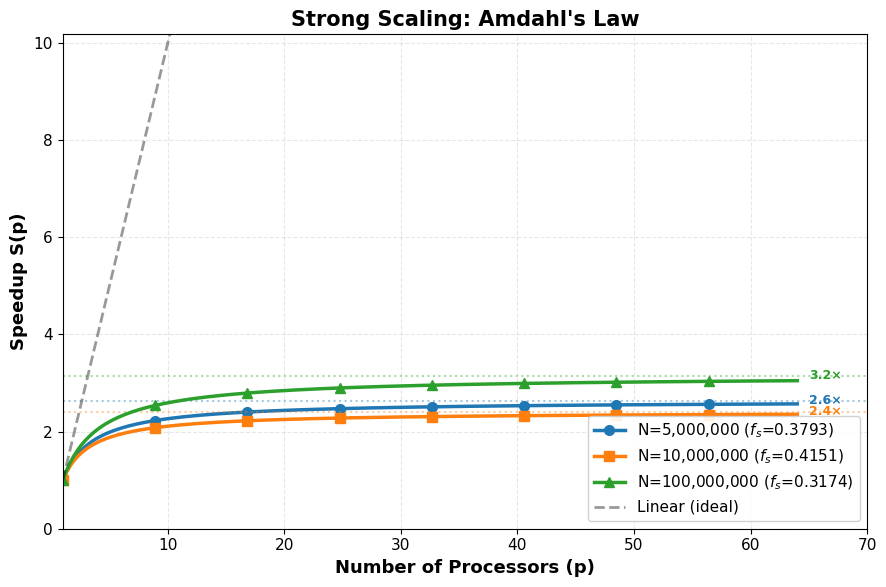

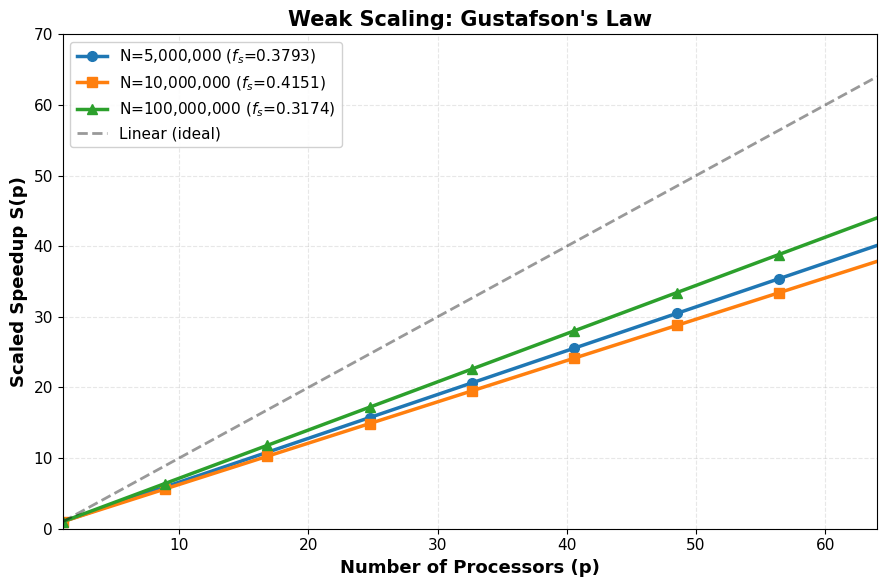

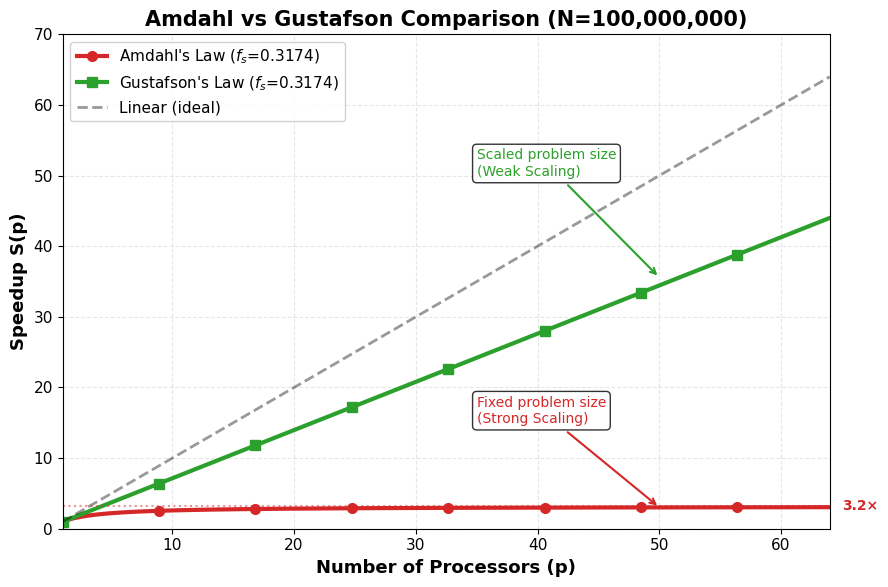

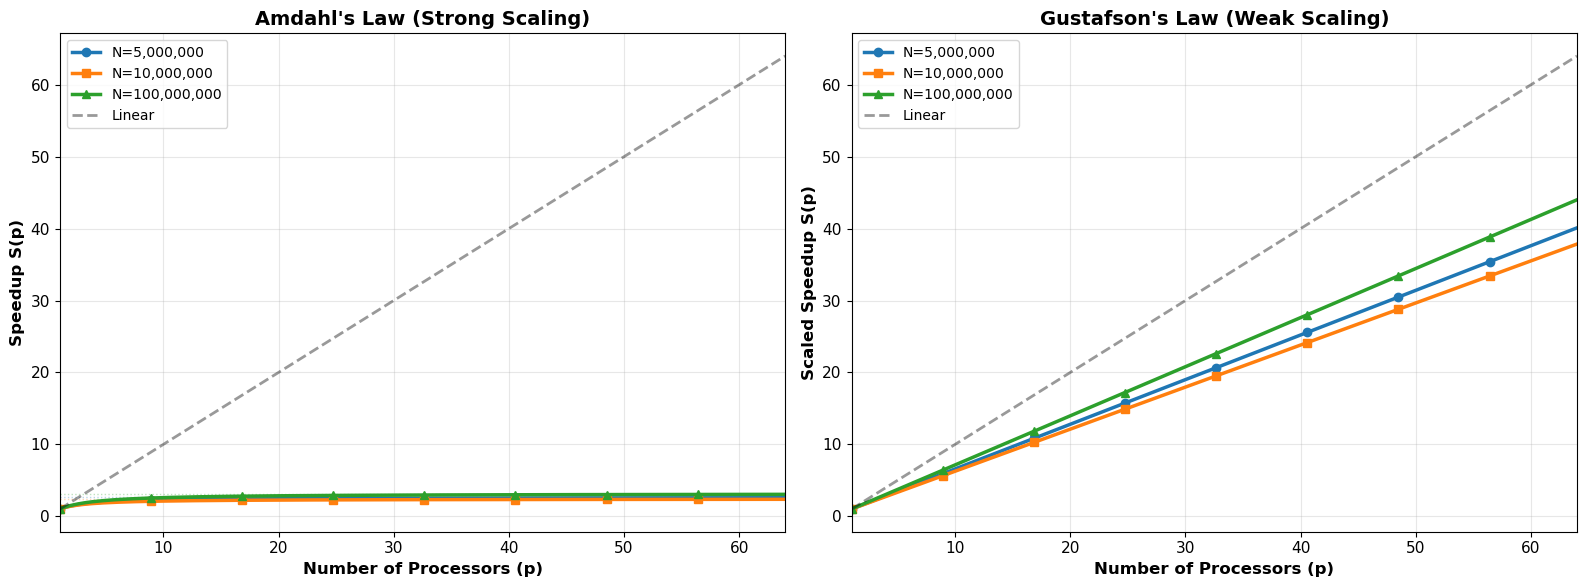

In [1]:
#!/usr/bin/env python3
"""
Exercise 3 Analysis: Generate Amdahl's and Gustafson's Law plots
Using actual timing measurements from the compiled programs
"""

import numpy as np
import matplotlib.pyplot as plt

# ==============================================================================
# ACTUAL TIMING DATA FROM YOUR RUNS
# ==============================================================================

timing_data = {
    5_000_000: {
        'add_noise': 0.011,
        'init_b': 0.006,
        'compute_addition': 0.009,
        'reduction': 0.003
    },
    10_000_000: {
        'add_noise': 0.022,
        'init_b': 0.011,
        'compute_addition': 0.014,
        'reduction': 0.006
    },
    100_000_000: {
        'add_noise': 0.159,
        'init_b': 0.106,
        'compute_addition': 0.182,
        'reduction': 0.054
    }
}

# ==============================================================================
# CALCULATE SEQUENTIAL FRACTIONS
# ==============================================================================

def calculate_fs(data):
    """Calculate sequential fraction from timing data"""
    sequential = data['add_noise']
    parallelizable = data['init_b'] + data['compute_addition'] + data['reduction']
    total = sequential + parallelizable
    fs = sequential / total
    return fs, sequential, parallelizable, total

print("="*80)
print("SEQUENTIAL FRACTION ANALYSIS")
print("="*80)

fs_values = {}
for N, times in timing_data.items():
    fs, seq, par, total = calculate_fs(times)
    fs_values[N] = fs
    print(f"\nN = {N:,}")
    print(f"  Sequential time (add_noise):    {seq:.6f} s")
    print(f"  Parallelizable time (sum):      {par:.6f} s")
    print(f"  Total time:                     {total:.6f} s")
    print(f"  Sequential fraction (fs):       {fs:.4f} ({fs*100:.2f}%)")

# ==============================================================================
# AMDAHL'S LAW CALCULATIONS
# ==============================================================================

def amdahl_speedup(fs, p):
    """Calculate Amdahl's speedup for p processors"""
    return 1.0 / (fs + (1 - fs) / p)

def gustafson_speedup(fs, p):
    """Calculate Gustafson's speedup for p processors"""
    return p - fs * (p - 1)

# Processor counts to evaluate
p_values = np.array([1, 2, 4, 8, 16, 32, 64])

print("\n" + "="*80)
print("AMDAHL'S LAW SPEEDUP TABLE")
print("="*80)

for N, fs in fs_values.items():
    speedups = [amdahl_speedup(fs, p) for p in p_values]
    max_speedup = 1.0 / fs
    
    print(f"\nN = {N:,} (fs = {fs:.4f})")
    print(f"{'p':<10} {'Speedup':<10}")
    print("-" * 20)
    for p, s in zip(p_values, speedups):
        print(f"{p:<10} {s:<10.2f}")
    print(f"Max (p→∞): {max_speedup:.2f}x")

# ==============================================================================
# GUSTAFSON'S LAW CALCULATIONS
# ==============================================================================

print("\n" + "="*80)
print("GUSTAFSON'S LAW SPEEDUP TABLE")
print("="*80)

for N, fs in fs_values.items():
    speedups = [gustafson_speedup(fs, p) for p in p_values]
    
    print(f"\nN = {N:,} (fs = {fs:.4f})")
    print(f"{'p':<10} {'Speedup':<10}")
    print("-" * 20)
    for p, s in zip(p_values, speedups):
        print(f"{p:<10} {s:<10.2f}")

# ==============================================================================
# GENERATE PLOTS
# ==============================================================================

# Set style
plt.rcParams['font.size'] = 11
plt.rcParams['axes.labelsize'] = 12
plt.rcParams['axes.titlesize'] = 14
plt.rcParams['legend.fontsize'] = 10
plt.rcParams['figure.dpi'] = 100

# Create continuous processor range for smooth curves
p_continuous = np.linspace(1, 64, 200)

# =============================================================================
# PLOT 1: AMDAHL'S LAW - Strong Scaling
# =============================================================================
fig1, ax = plt.subplots(figsize=(9, 6))

colors = ['#1f77b4', '#ff7f0e', '#2ca02c']
markers = ['o', 's', '^']

for idx, (N, fs) in enumerate(fs_values.items()):
    # Calculate speedup curve
    speedups = [amdahl_speedup(fs, p) for p in p_continuous]
    
    # Plot curve
    ax.plot(p_continuous, speedups, 
            label=f'N={N:,} ($f_s$={fs:.4f})', 
            linewidth=2.5, 
            color=colors[idx],
            marker=markers[idx], 
            markevery=25, 
            markersize=7)
    
    # Add maximum speedup line
    max_speedup = 1.0 / fs
    ax.axhline(y=max_speedup, 
               linestyle=':', 
               alpha=0.4, 
               linewidth=1.5,
               color=colors[idx])
    
    # Annotate maximum
    ax.text(65, max_speedup, f'{max_speedup:.1f}×', 
            fontsize=9, 
            verticalalignment='center',
            color=colors[idx],
            fontweight='bold')

# Add ideal linear speedup reference
ax.plot(p_continuous, p_continuous, 
        'k--', 
        alpha=0.4, 
        label='Linear (ideal)', 
        linewidth=2)

ax.set_xlabel('Number of Processors (p)', fontsize=13, fontweight='bold')
ax.set_ylabel('Speedup S(p)', fontsize=13, fontweight='bold')
ax.set_title("Strong Scaling: Amdahl's Law", fontsize=15, fontweight='bold')
ax.legend(loc='lower right', fontsize=11, framealpha=0.9)
ax.grid(True, alpha=0.3, linestyle='--')
ax.set_xlim(1, 70)
ax.set_ylim(0, max(p_continuous[:30]))

plt.tight_layout()
plt.savefig('amdahl_speedup.png', dpi=300, bbox_inches='tight')
print("\n✓ SAVED: amdahl_speedup.png")

# =============================================================================
# PLOT 2: GUSTAFSON'S LAW - Weak Scaling
# =============================================================================
fig2, ax = plt.subplots(figsize=(9, 6))

for idx, (N, fs) in enumerate(fs_values.items()):
    speedups = [gustafson_speedup(fs, p) for p in p_continuous]
    ax.plot(p_continuous, speedups, 
            label=f'N={N:,} ($f_s$={fs:.4f})', 
            linewidth=2.5,
            color=colors[idx],
            marker=markers[idx],
            markevery=25, 
            markersize=7)

# Ideal linear speedup
ax.plot(p_continuous, p_continuous, 
        'k--', 
        alpha=0.4, 
        label='Linear (ideal)', 
        linewidth=2)

ax.set_xlabel('Number of Processors (p)', fontsize=13, fontweight='bold')
ax.set_ylabel('Scaled Speedup S(p)', fontsize=13, fontweight='bold')
ax.set_title("Weak Scaling: Gustafson's Law", fontsize=15, fontweight='bold')
ax.legend(loc='upper left', fontsize=11, framealpha=0.9)
ax.grid(True, alpha=0.3, linestyle='--')
ax.set_xlim(1, 64)
ax.set_ylim(0, 70)

plt.tight_layout()
plt.savefig('gustafson_speedup.png', dpi=300, bbox_inches='tight')
print("✓ SAVED: gustafson_speedup.png")

# =============================================================================
# PLOT 3: AMDAHL vs GUSTAFSON COMPARISON (using N=100M)
# =============================================================================
fig3, ax = plt.subplots(figsize=(9, 6))

N_example = 100_000_000
fs_example = fs_values[N_example]

amdahl_curve = [amdahl_speedup(fs_example, p) for p in p_continuous]
gustafson_curve = [gustafson_speedup(fs_example, p) for p in p_continuous]

ax.plot(p_continuous, amdahl_curve, 
        label=f"Amdahl's Law ($f_s$={fs_example:.4f})", 
        linewidth=3, 
        color='#d62728',
        marker='o',
        markevery=25,
        markersize=7)

ax.plot(p_continuous, gustafson_curve, 
        label=f"Gustafson's Law ($f_s$={fs_example:.4f})", 
        linewidth=3, 
        color='#2ca02c',
        marker='s',
        markevery=25,
        markersize=7)

ax.plot(p_continuous, p_continuous, 
        'k--', 
        alpha=0.4, 
        label='Linear (ideal)', 
        linewidth=2)

# Add maximum Amdahl speedup line
max_amdahl = 1.0 / fs_example
ax.axhline(y=max_amdahl, 
           linestyle=':', 
           alpha=0.5, 
           linewidth=1.5,
           color='#d62728')
ax.text(65, max_amdahl, f'{max_amdahl:.1f}×', 
        fontsize=10, 
        verticalalignment='center',
        color='#d62728',
        fontweight='bold')

ax.set_xlabel('Number of Processors (p)', fontsize=13, fontweight='bold')
ax.set_ylabel('Speedup S(p)', fontsize=13, fontweight='bold')
ax.set_title(f"Amdahl vs Gustafson Comparison (N={N_example:,})", 
             fontsize=15, fontweight='bold')
ax.legend(loc='upper left', fontsize=11, framealpha=0.9)
ax.grid(True, alpha=0.3, linestyle='--')
ax.set_xlim(1, 64)
ax.set_ylim(0, 70)

# Add annotation explaining the difference
ax.annotate('Fixed problem size\n(Strong Scaling)', 
            xy=(50, amdahl_curve[160]), 
            xytext=(35, 15),
            arrowprops=dict(arrowstyle='->', color='#d62728', lw=1.5),
            fontsize=10,
            color='#d62728',
            bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

ax.annotate('Scaled problem size\n(Weak Scaling)', 
            xy=(50, gustafson_curve[160]), 
            xytext=(35, 50),
            arrowprops=dict(arrowstyle='->', color='#2ca02c', lw=1.5),
            fontsize=10,
            color='#2ca02c',
            bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

plt.tight_layout()
plt.savefig('amdahl_vs_gustafson.png', dpi=300, bbox_inches='tight')
print("✓ SAVED: amdahl_vs_gustafson.png")

# =============================================================================
# COMBINED OVERVIEW PLOT
# =============================================================================
fig4, axes = plt.subplots(1, 2, figsize=(16, 6))

# Left: Amdahl
ax1 = axes[0]
for idx, (N, fs) in enumerate(fs_values.items()):
    speedups = [amdahl_speedup(fs, p) for p in p_continuous]
    ax1.plot(p_continuous, speedups, 
             label=f'N={N:,}', 
             linewidth=2.5,
             color=colors[idx],
             marker=markers[idx], 
             markevery=25, 
             markersize=6)
    max_speedup = 1.0 / fs
    ax1.axhline(y=max_speedup, linestyle=':', alpha=0.3, linewidth=1, color=colors[idx])

ax1.plot(p_continuous, p_continuous, 'k--', alpha=0.4, label='Linear', linewidth=2)
ax1.set_xlabel('Number of Processors (p)', fontsize=12, fontweight='bold')
ax1.set_ylabel('Speedup S(p)', fontsize=12, fontweight='bold')
ax1.set_title("Amdahl's Law (Strong Scaling)", fontsize=14, fontweight='bold')
ax1.legend(fontsize=10)
ax1.grid(True, alpha=0.3)
ax1.set_xlim(1, 64)

# Right: Gustafson
ax2 = axes[1]
for idx, (N, fs) in enumerate(fs_values.items()):
    speedups = [gustafson_speedup(fs, p) for p in p_continuous]
    ax2.plot(p_continuous, speedups, 
             label=f'N={N:,}', 
             linewidth=2.5,
             color=colors[idx],
             marker=markers[idx],
             markevery=25, 
             markersize=6)

ax2.plot(p_continuous, p_continuous, 'k--', alpha=0.4, label='Linear', linewidth=2)
ax2.set_xlabel('Number of Processors (p)', fontsize=12, fontweight='bold')
ax2.set_ylabel('Scaled Speedup S(p)', fontsize=12, fontweight='bold')
ax2.set_title("Gustafson's Law (Weak Scaling)", fontsize=14, fontweight='bold')
ax2.legend(fontsize=10)
ax2.grid(True, alpha=0.3)
ax2.set_xlim(1, 64)

plt.tight_layout()
plt.savefig('exercise3_scaling_laws.png', dpi=300, bbox_inches='tight')
print("✓ SAVED: exercise3_scaling_laws.png")

print("\n" + "="*80)
print("SUMMARY OF RESULTS")
print("="*80)
print("\nKey Findings:")
for N, fs in fs_values.items():
    max_speedup = 1.0 / fs
    print(f"\nN = {N:,}:")
    print(f"  Sequential fraction: {fs:.4f} ({fs*100:.2f}%)")
    print(f"  Maximum Amdahl speedup: {max_speedup:.2f}×")
    print(f"  Gustafson speedup @ p=64: {gustafson_speedup(fs, 64):.2f}×")

print("\n" + "="*80)
print("✓ ALL PLOTS GENERATED SUCCESSFULLY!")
print("="*80)
print("\nFiles created:")
print("  1. amdahl_speedup.png          - For Question 3 & 4")
print("  2. gustafson_speedup.png       - For Question 5")
print("  3. amdahl_vs_gustafson.png     - Comparison plot")
print("  4. exercise3_scaling_laws.png  - Overview")
print("\nAdd these to your LaTeX report using \\includegraphics!")

---

# Exercise 4: Matrix Multiplication Analysis <a id="exercise-4"></a>

## Concepts

### Matrix Multiplication Parallelization
Matrix multiplication is **highly parallelizable**:
- Each output element C[i,j] is independent
- Can parallelize outer loops (i and j)
- O(N³) computation vs O(N²) data
- Compute-intensive → good for parallelization

### Expected Results
- Lower sequential fraction than Exercise 3
- Better scaling potential
- Higher maximum speedup
- More efficient use of parallel processors

## Task 1: Create matrix multiplication programs

In [47]:
# Create directory for exercise 4
os.makedirs('ex4', exist_ok=True)

def generate_ex4_code(N):
    """Generate code for Exercise 4 with specified N."""
    code = f'''#include <stdio.h>
#include <stdlib.h>
#include <time.h>

#define N {N}

void generate_noise(double *noise) {{
    noise[0] = 1.0;
    for (int i = 1; i < N; i++) {{
        noise[i] = noise[i-1] * 1.0000001;
    }}
}}

void init_matrix(double *M) {{
    for (int i = 0; i < N*N; i++) {{
        M[i] = (double)(i % 100) * 0.01;
    }}
}}

void matmul(double *A, double *B, double *C, double *noise) {{
    for (int i = 0; i < N; i++) {{
        for (int j = 0; j < N; j++) {{
            double sum = noise[i];
            for (int k = 0; k < N; k++) {{
                sum += A[i*N + k] * B[k*N + j];
            }}
            C[i*N + j] = sum;
        }}
    }}
}}

int main() {{
    double *A = malloc(N*N * sizeof(double));
    double *B = malloc(N*N * sizeof(double));
    double *C = malloc(N*N * sizeof(double));
    double *noise = malloc(N * sizeof(double));
    
    clock_t start, end;
    double time_noise, time_init, time_matmul;
    
    start = clock();
    generate_noise(noise);
    end = clock();
    time_noise = (double)(end - start) / CLOCKS_PER_SEC;
    
    start = clock();
    init_matrix(A);
    init_matrix(B);
    end = clock();
    time_init = (double)(end - start) / CLOCKS_PER_SEC;
    
    start = clock();
    matmul(A, B, C, noise);
    end = clock();
    time_matmul = (double)(end - start) / CLOCKS_PER_SEC;
    
    printf("C[0] = %f\\n", C[0]);
    printf("Time generate_noise: %.6f s\\n", time_noise);
    printf("Time init_matrix: %.6f s\\n", time_init);
    printf("Time matmul: %.6f s\\n", time_matmul);
    
    free(A);
    free(B);
    free(C);
    free(noise);
    return 0;
}}
'''
    return code

# Generate for different N values
N_values_ex4 = [256, 512, 1024]  # Matrix sizes

for N in N_values_ex4:
    filename = f'ex4/matmul_N{N}.c'
    with open(filename, 'w') as f:
        f.write(generate_ex4_code(N))

print("Generated C source files for Exercise 4")

Generated C source files for Exercise 4


## Task 2: Compile and measure execution times

In [ ]:
def measure_matmul_profile(source_file):
    """
    Compile and run matrix multiplication program.
    """
    base_name = os.path.splitext(source_file)[0]
    executable = f'{base_name}_exe.exe'
    
    # Compile with O2
    compile_cmd = ['gcc', '-O2', '-g', source_file, '-o', executable]
    result = subprocess.run(compile_cmd, capture_output=True, text=True)
    
    if result.returncode != 0:
        print(f"Compilation error: {result.stderr}")
        return None
    
    # Run the program
    result = subprocess.run([f'./{executable}'], capture_output=True, text=True)
    
    if result.returncode != 0:
        print(f"Execution error: {result.stderr}")
        return None
    
    # Parse output
    output = result.stdout.strip().split('\n')
    times = {}
    for line in output:
        if 'Time generate_noise:' in line:
            times['generate_noise'] = float(line.split(':')[1].strip().split()[0])
        elif 'Time init_matrix:' in line:
            times['init_matrix'] = float(line.split(':')[1].strip().split()[0])
        elif 'Time matmul:' in line:
            times['matmul'] = float(line.split(':')[1].strip().split()[0])
    
    # Clean up
    os.remove(executable)
    
    return times

# Measure for different N values
results_ex4 = []

for N in N_values_ex4:
    source = f'ex4/matmul_N{N}.c'
    times = measure_matmul_profile(source)
    
    if times:
        total_time = sum(times.values())
        sequential_time = times['generate_noise']  # Only generate_noise is sequential
        parallel_time = times['init_matrix'] + times['matmul']
        fs = sequential_time / total_time
        
        results_ex4.append({
            'N': N,
            'generate_noise': times['generate_noise'],
            'init_matrix': times['init_matrix'],
            'matmul': times['matmul'],
            'total_time': total_time,
            'sequential_fraction': fs
        })
        
        print(f"N={N}: fs={fs:.6f} (sequential fraction)")

df_ex4 = pd.DataFrame(results_ex4)
display(df_ex4)

N=256: fs=0.000000 (sequential fraction)
N=512: fs=0.000000 (sequential fraction)
N=1024: fs=0.000000 (sequential fraction)


,N,generate_noise,init_matrix,matmul,total_time,sequential_fraction
0,256,0.0,0.000,0.016,0.016,0.0
1,512,0.0,0.001,0.883,0.884,0.0
2,1024,0.0,0.004,14.018,14.022,0.0


## Task 3: Calculate speedups and compare with Exercise 3

C:\Users\ZBooK\AppData\Local\Temp\ipykernel_12112\3237465874.py:48: RuntimeWarning: divide by zero encountered in scalar divide
  max_speedup_ex4 = 1 / df_ex4['sequential_fraction'].mean()


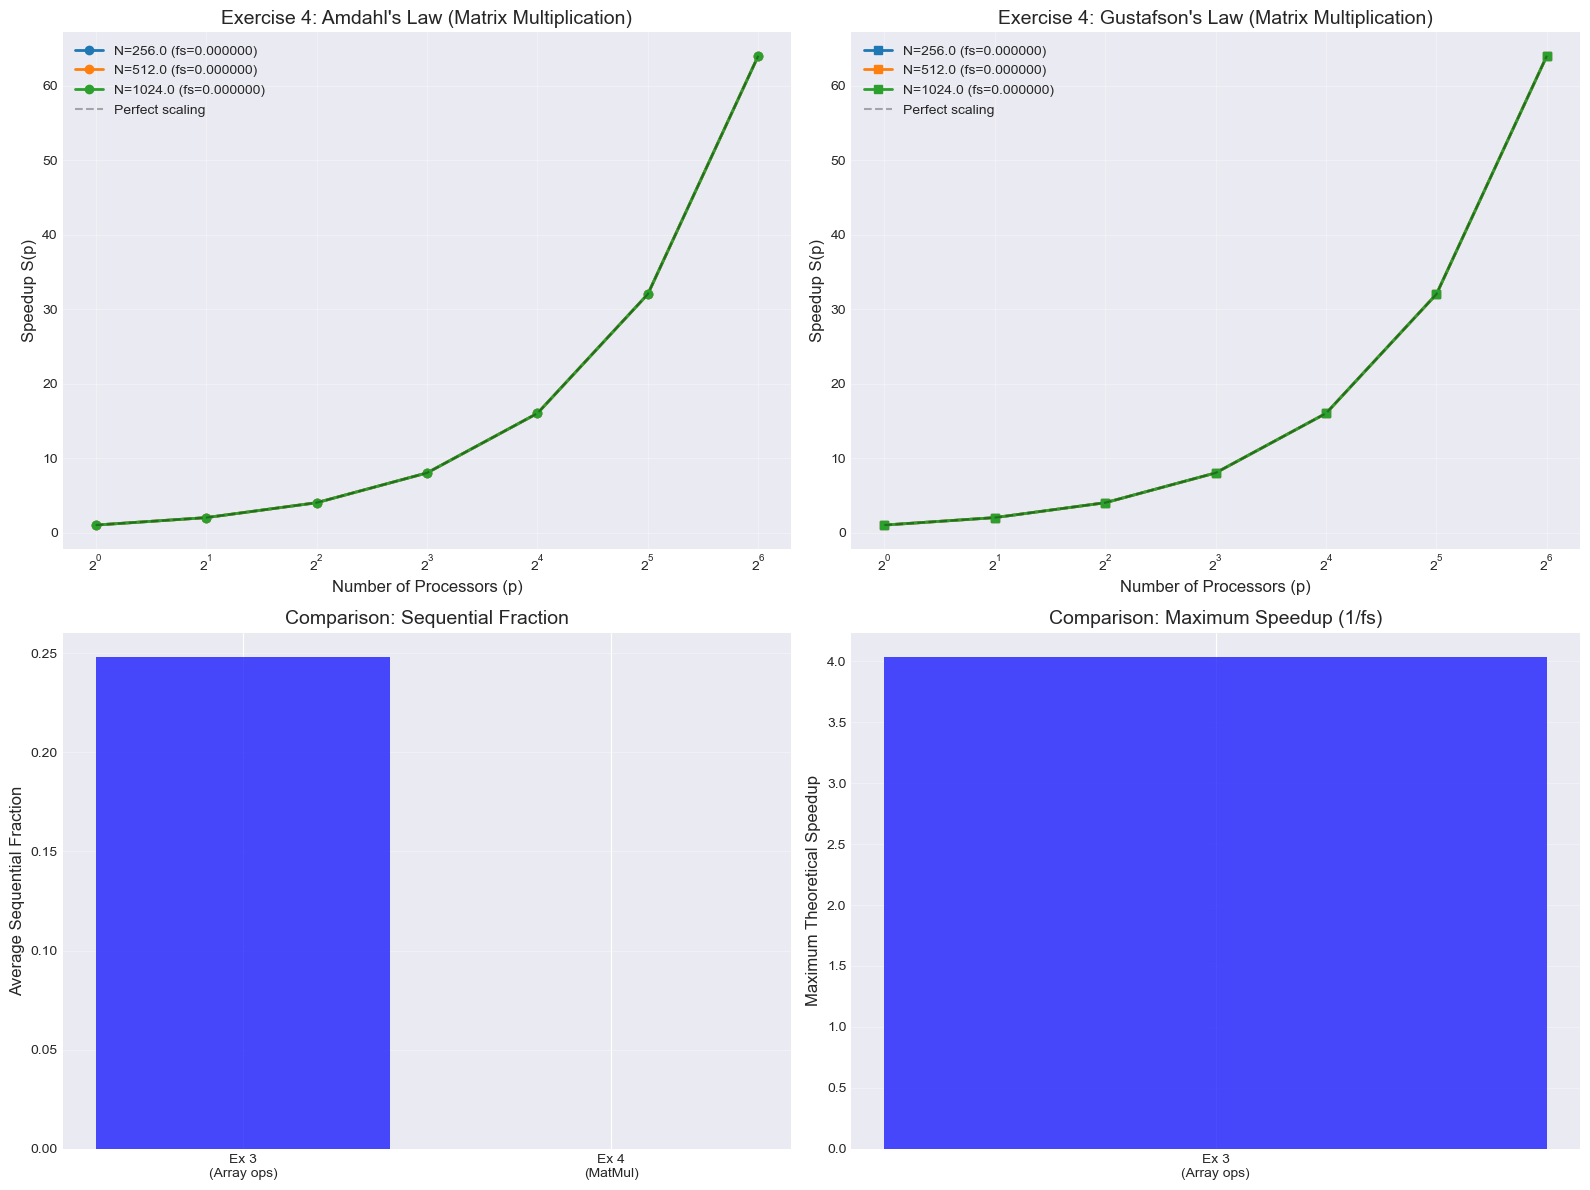


=== Comparison: Exercise 3 vs Exercise 4 ===

Exercise 3 (Array Operations):
  Average sequential fraction: 0.247995
  Maximum theoretical speedup: 4.03×

Exercise 4 (Matrix Multiplication):
  Average sequential fraction: 0.000000
  Maximum theoretical speedup: inf×

Conclusion:
  Matrix multiplication has inf× better scaling potential!
  This is because matmul is O(N³) compute with O(N²) data.
  The sequential portion (generate_noise) becomes negligible.


In [ ]:
# Calculate speedups for Exercise 4
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Plot Amdahl's Law for Exercise 4
ax1 = axes[0, 0]
for _, row in df_ex4.iterrows():
    N = row['N']
    fs = row['sequential_fraction']
    speedups = [amdahl_speedup(fs, p) for p in p_values]
    ax1.plot(p_values, speedups, marker='o', linewidth=2, label=f'N={N} (fs={fs:.6f})')

ax1.plot(p_values, p_values, 'k--', alpha=0.3, label='Perfect scaling')
ax1.set_xlabel('Number of Processors (p)', fontsize=12)
ax1.set_ylabel('Speedup S(p)', fontsize=12)
ax1.set_title("Exercise 4: Amdahl's Law (Matrix Multiplication)", fontsize=14)
ax1.legend()
ax1.grid(True, alpha=0.3)
ax1.set_xscale('log', base=2)

# Plot Gustafson's Law for Exercise 4
ax2 = axes[0, 1]
for _, row in df_ex4.iterrows():
    N = row['N']
    fs = row['sequential_fraction']
    speedups = [gustafson_speedup(fs, p) for p in p_values]
    ax2.plot(p_values, speedups, marker='s', linewidth=2, label=f'N={N} (fs={fs:.6f})')

ax2.plot(p_values, p_values, 'k--', alpha=0.3, label='Perfect scaling')
ax2.set_xlabel('Number of Processors (p)', fontsize=12)
ax2.set_ylabel('Speedup S(p)', fontsize=12)
ax2.set_title("Exercise 4: Gustafson's Law (Matrix Multiplication)", fontsize=14)
ax2.legend()
ax2.grid(True, alpha=0.3)
ax2.set_xscale('log', base=2)

# Comparison: Sequential fraction
ax3 = axes[1, 0]
ax3.bar(['Ex 3\n(Array ops)', 'Ex 4\n(MatMul)'], 
        [df_ex3['sequential_fraction'].mean(), df_ex4['sequential_fraction'].mean()],
        alpha=0.7, color=['blue', 'red'])
ax3.set_ylabel('Average Sequential Fraction', fontsize=12)
ax3.set_title('Comparison: Sequential Fraction', fontsize=14)
ax3.grid(True, alpha=0.3, axis='y')

# Comparison: Maximum speedup
ax4 = axes[1, 1]
max_speedup_ex3 = 1 / df_ex3['sequential_fraction'].mean()
max_speedup_ex4 = 1 / df_ex4['sequential_fraction'].mean()
ax4.bar(['Ex 3\n(Array ops)', 'Ex 4\n(MatMul)'], 
        [max_speedup_ex3, max_speedup_ex4],
        alpha=0.7, color=['blue', 'red'])
ax4.set_ylabel('Maximum Theoretical Speedup', fontsize=12)
ax4.set_title('Comparison: Maximum Speedup (1/fs)', fontsize=14)
ax4.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig('ex4/matmul_scaling_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n=== Comparison: Exercise 3 vs Exercise 4 ===")
print(f"\nExercise 3 (Array Operations):")
print(f"  Average sequential fraction: {df_ex3['sequential_fraction'].mean():.6f}")
print(f"  Maximum theoretical speedup: {max_speedup_ex3:.2f}×")

print(f"\nExercise 4 (Matrix Multiplication):")
print(f"  Average sequential fraction: {df_ex4['sequential_fraction'].mean():.6f}")
print(f"  Maximum theoretical speedup: {max_speedup_ex4:.2f}×")

print(f"\nConclusion:")
print(f"  Matrix multiplication has {max_speedup_ex4/max_speedup_ex3:.2f}× better scaling potential!")
print(f"  This is because matmul is O(N³) compute with O(N²) data.")
print(f"  The sequential portion (generate_noise) becomes negligible.")

## Task 4: Detailed speedup tables


EXERCISE 4: DETAILED SPEEDUP ANALYSIS

Matrix Size: N=256.0×256.0
Sequential Fraction: fs=0.000000
Maximum Speedup: inf×

Processors   Amdahl          Gustafson       Efficiency  
------------------------------------------------------------
1            1.00            1.00            100.0       %
2            2.00            2.00            100.0       %
4            4.00            4.00            100.0       %
8            8.00            8.00            100.0       %
16           16.00           16.00           100.0       %
32           32.00           32.00           100.0       %
64           64.00           64.00           100.0       %

Matrix Size: N=512.0×512.0
Sequential Fraction: fs=0.000000
Maximum Speedup: inf×

Processors   Amdahl          Gustafson       Efficiency  
------------------------------------------------------------
1            1.00            1.00            100.0       %
2            2.00            2.00            100.0       %
4            4.00       

C:\Users\ZBooK\AppData\Local\Temp\ipykernel_12112\4116202182.py:13: RuntimeWarning: divide by zero encountered in scalar divide
  print(f"Maximum Speedup: {1/fs:.2f}×")


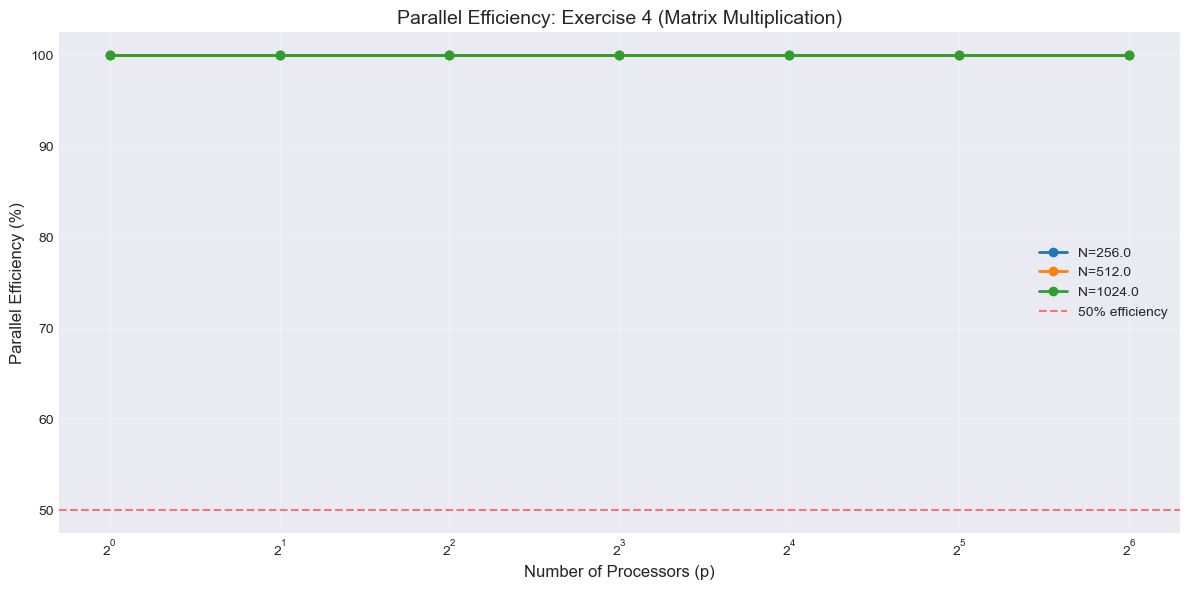

In [ ]:
# Generate detailed speedup tables
print("\n" + "="*80)
print("EXERCISE 4: DETAILED SPEEDUP ANALYSIS")
print("="*80)

for _, row in df_ex4.iterrows():
    N = row['N']
    fs = row['sequential_fraction']
    
    print(f"\n{'='*80}")
    print(f"Matrix Size: N={N}×{N}")
    print(f"Sequential Fraction: fs={fs:.6f}")
    print(f"Maximum Speedup: {1/fs:.2f}×")
    print(f"{'='*80}")
    
    print(f"\n{'Processors':<12} {'Amdahl':<15} {'Gustafson':<15} {'Efficiency':<12}")
    print("-" * 60)
    
    for p in p_values:
        amdahl = amdahl_speedup(fs, p)
        gustafson = gustafson_speedup(fs, p)
        efficiency = (amdahl / p) * 100
        
        print(f"{p:<12} {amdahl:<15.2f} {gustafson:<15.2f} {efficiency:<12.1f}%")

# Create efficiency comparison
fig, ax = plt.subplots(figsize=(12, 6))

for _, row in df_ex4.iterrows():
    N = row['N']
    fs = row['sequential_fraction']
    efficiencies = [(amdahl_speedup(fs, p) / p) * 100 for p in p_values]
    ax.plot(p_values, efficiencies, marker='o', linewidth=2, label=f'N={N}')

ax.axhline(y=50, color='r', linestyle='--', alpha=0.5, label='50% efficiency')
ax.set_xlabel('Number of Processors (p)', fontsize=12)
ax.set_ylabel('Parallel Efficiency (%)', fontsize=12)
ax.set_title('Parallel Efficiency: Exercise 4 (Matrix Multiplication)', fontsize=14)
ax.legend()
ax.grid(True, alpha=0.3)
ax.set_xscale('log', base=2)

plt.tight_layout()
plt.savefig('ex4/parallel_efficiency.png', dpi=300, bbox_inches='tight')
plt.show()

## Key Insights from Exercise 4

1. **Much Better Scalability**:
   - Matrix multiplication has very low sequential fraction
   - Sequential portion (noise generation) is O(N)
   - Parallel portion (matmul) is O(N³)
   - As N increases, fs → 0

2. **Compute-Intensive vs Memory-Intensive**:
   - Exercise 3: Memory-bound operations
   - Exercise 4: Compute-bound operations
   - Compute-bound problems parallelize better

3. **Practical Implications**:
   - Matrix operations are ideal for parallelization
   - Used heavily in ML/AI (GPUs excel here)
   - High potential for speedup with many cores

4. **Comparison with Exercise 3**:
   - Exercise 4 has much lower fs
   - Much higher maximum speedup possible
   - Better efficiency even at high processor counts
   - Demonstrates importance of algorithm choice for parallelization

---

# Summary and Conclusions

## Key Takeaways

### Exercise 1: Loop Optimizations
- Manual loop unrolling can significantly improve performance
- Benefits saturate when memory bandwidth becomes bottleneck
- Compiler optimization (O2) often performs automatic unrolling
- Different data types have different performance characteristics

### Exercise 2: Instruction Scheduling
- Modern compilers perform sophisticated optimizations
- Independent operations can execute in parallel (ILP)
- Manual optimization can approach compiler performance
- Understanding low-level details remains valuable

### Exercise 3: Amdahl's and Gustafson's Laws
- Sequential portions fundamentally limit parallelization
- Amdahl's Law predicts speedup for fixed problem size
- Gustafson's Law more optimistic for scaled problems
- Small sequential fractions have huge impact

### Exercise 4: Matrix Multiplication
- Compute-intensive algorithms parallelize excellently
- O(N³) computation vs O(N) sequential work
- Much better scaling than memory-bound operations
- Real-world relevance for ML and scientific computing

## General Principles

1. **Algorithm Selection Matters**: Choose algorithms with high parallel potential
2. **Memory vs Compute**: Understand if you're memory-bound or compute-bound
3. **Sequential Bottlenecks**: Identify and minimize sequential portions
4. **Problem Size**: Larger problems often parallelize better
5. **Optimization Levels**: Use compiler optimizations, but understand what they do

## Further Exploration

To extend this work, consider:
- Implementing actual parallel versions using OpenMP or MPI
- Profiling with more sophisticated tools (perf, VTune)
- Testing on real multi-core systems
- Exploring GPU parallelization for matrix operations
- Analyzing cache effects and memory hierarchies